In [85]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import graph_tool.all as gt
import nltk
import itertools

from collections import defaultdict, Counter
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [2]:
# Data importing
data_folder = "../data/Data_citation/" 


author_paper_biadj = np.loadtxt(f"{data_folder}authorPaperBiadj.txt", delimiter="\t", dtype=int)
author_list = np.loadtxt(f"{data_folder}authorList.txt", delimiter="\t", dtype=str)
paper_cit_adj = pd.read_csv(f"{data_folder}paperCitAdj.txt", delimiter=" ", header=None)
paper_list = pd.read_csv(f"{data_folder}paperList.txt", sep=",", header=0)

1. `paper_list` stores the text information.
2. `author_list` stores the name of the authors
3. `author_paper_biadj` stores the author - paper relationship.
4. `paper_cit_adj` stores the citation network


In [3]:
# Data cleaning

## Creating a new column to store the word count of each abstract
paper_list['word_count'] = paper_list['abstract'].astype(str).apply(lambda x: len(x.split()))

## Finding the paper index with insufficient word
remove_index = paper_list[paper_list['word_count'] < 20].index.tolist()

## Removing
filtered_papers = paper_list.drop(index=remove_index)
filtered_cit_adj = paper_cit_adj.drop(index=remove_index, columns=remove_index)

author_paper_df = pd.DataFrame(author_paper_biadj, columns=paper_list.index)
filtered_author_paper = author_paper_df.drop(columns=remove_index)

# Graph building

1. Node are the abstracts
2. Edges are the citation(directed)

In [6]:
# Graph building
G2 = nx.from_pandas_adjacency(filtered_cit_adj, create_using=nx.Graph)

# Save the graph as an edge list
edge_list = list(G2.edges())
edge_df = pd.DataFrame(edge_list, columns=["Source", "Target"])

print("Number of Nodes (Documents):", G2.number_of_nodes())
print("Number of Edges (Citations):", G2.number_of_edges())

Number of Nodes (Documents): 3206
Number of Edges (Citations): 5669


In [7]:
coauthor_edges = set()
num_authors = filtered_author_paper.shape[0]

for author in range(num_authors):
    # Use .iloc to get the row for the current author.
    row = filtered_author_paper.iloc[author]
    # Get the list of paper indices (i.e. the column labels) where the value is nonzero.
    papers = [col for col, val in row.items() if val != 0]
    # For every unordered pair of papers, add one undirected edge.
    for p, q in itertools.combinations(papers, 2):
        edge = tuple(sorted((p, q)))
        coauthor_edges.add(edge)

added_edges = 0
for edge in coauthor_edges:
    if not G2.has_edge(*edge):
        G2.add_edge(*edge)
        added_edges += 1

print("Added", added_edges, "coauthorship edges.")
print("New total number of edges:", G2.number_of_edges())

Added 15687 coauthorship edges.
New total number of edges: 21356


In [8]:
# Filtering for the largest CC
largest_cc = max(nx.connected_components(G2), key=len)

# Create a new graph that is the subgraph induced by the largest connected component and make a copy of it
G2 = G2.subgraph(largest_cc).copy()

print("Number of nodes after filtering:", G2.number_of_nodes())
print("Number of edges after filtering:", G2.number_of_edges())

Number of nodes after filtering: 2955
Number of edges after filtering: 21313


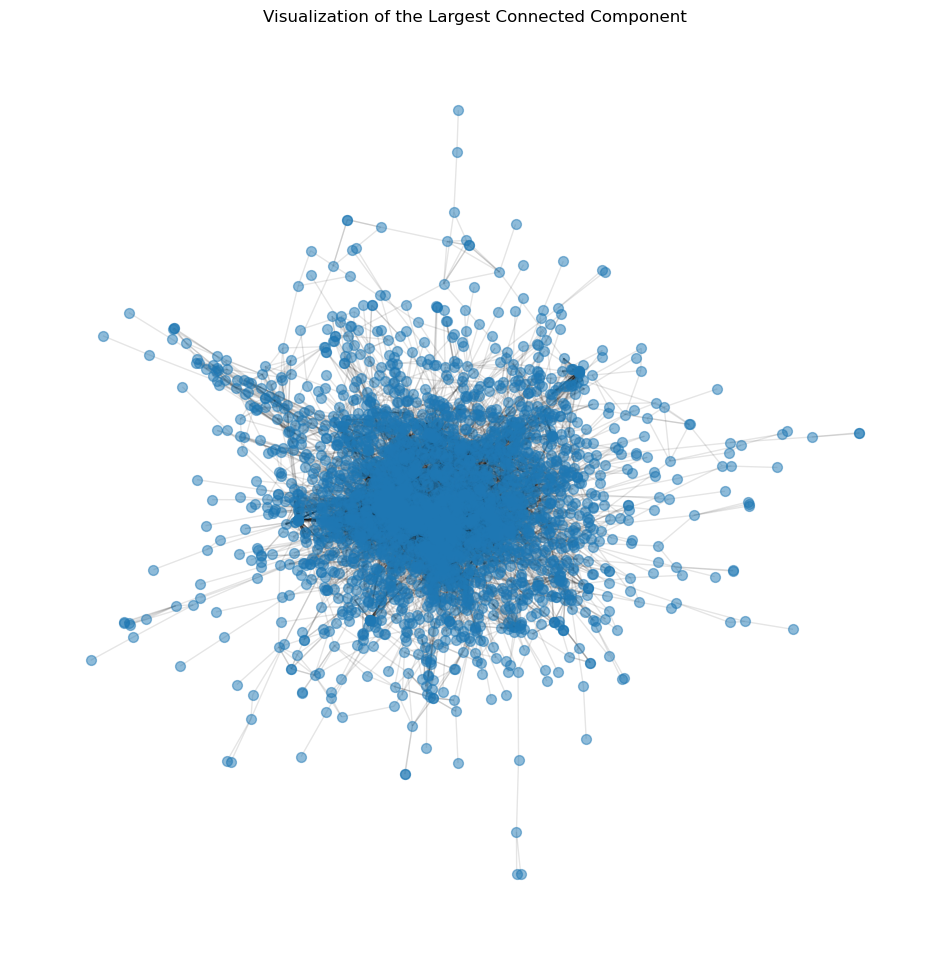

In [9]:
# Compute layout for visualization
pos = nx.spring_layout(G2, seed=42)  # Use spring layout for positioning

# Create the plot
plt.figure(figsize=(12, 12))

# Draw nodes with a low alpha to reduce overplotting
nx.draw_networkx_nodes(G2, pos, node_size=50, alpha=0.5)

# Draw edges with a lower alpha value
nx.draw_networkx_edges(G2, pos, alpha=0.1)

# Remove axes for clarity and add a title
plt.axis("off")
plt.title("Visualization of the Largest Connected Component")
plt.show()

# SBM

In [31]:
# -------------------------------
# Build a graph-tool graph from the NetworkX graph, storing original paper IDs.
# -------------------------------
G_gt = gt.Graph(directed=False)
# Create a mapping from paper ID (from G2.nodes()) to a graph-tool vertex.
node_map = {paper_id: G_gt.add_vertex() for paper_id in G2.nodes()}

# Add edges to the graph-tool graph
for src, tgt in G2.edges():
    G_gt.add_edge(node_map[src], node_map[tgt])

# Create a vertex property to store the original paper ID.
paper_id_prop = G_gt.new_vertex_property("int")
for paper_id, vertex in node_map.items():
    paper_id_prop[vertex] = int(paper_id)

In [32]:
# -------------------------------
# Run SBM
# -------------------------------
state = gt.minimize_blockmodel_dl(G_gt, state_args={"B": 5})
blocks2 = state.get_blocks()

In [149]:
# -------------------------------
# Compute community sizes and filter out small communities.
# -------------------------------
community_labels = blocks2.a  # NumPy array of community labels
unique, counts = np.unique(community_labels, return_counts=True)
community_sizes = dict(zip(unique, counts))
print("Community sizes:", community_sizes)

# Set the minimum community size threshold.
min_size = 30

def vfilt(v):
    # Keep only vertices belonging to communities with size at least min_size.
    return community_sizes[blocks2[v]] >= min_size

G_filtered = gt.GraphView(G_gt, vfilt=vfilt)
print("Number of nodes after filtering:", G_filtered.num_vertices())
print("Number of edges after filtering:", G_filtered.num_edges())

# -------------------------------
# Extract the original paper IDs from the filtered graph.
# -------------------------------
filtered_paper_ids = {int(paper_id_prop[v]) for v in G_filtered.vertices()}
print("Number of filtered paper IDs:", len(filtered_paper_ids))

# -------------------------------
# Filter the papers DataFrame to include only those documents in large communities.
# -------------------------------
filtered_paper_list = filtered_papers.loc[filtered_papers.index.isin(filtered_paper_ids)]
print("Filtered paper_list shape:", filtered_paper_list.shape)

Community sizes: {98: 7, 172: 112, 189: 32, 196: 57, 253: 41, 282: 41, 304: 29, 307: 31, 342: 31, 344: 23, 353: 10, 393: 33, 457: 44, 476: 44, 524: 40, 564: 52, 585: 7, 592: 29, 644: 37, 673: 18, 736: 71, 738: 47, 747: 21, 763: 28, 793: 23, 852: 25, 883: 101, 918: 75, 925: 62, 960: 82, 987: 90, 1041: 25, 1047: 81, 1106: 34, 1172: 52, 1329: 77, 1331: 69, 1365: 60, 1376: 61, 1385: 20, 1442: 31, 1603: 74, 1607: 63, 1662: 27, 1675: 52, 1717: 43, 1719: 42, 1723: 13, 1769: 36, 1831: 22, 1878: 83, 2013: 28, 2117: 24, 2149: 25, 2150: 69, 2159: 94, 2162: 28, 2239: 22, 2245: 24, 2298: 6, 2324: 15, 2376: 48, 2417: 39, 2476: 43, 2590: 8, 2593: 50, 2804: 18, 2846: 34, 2848: 22, 2925: 50}
Number of nodes after filtering: 2408
Number of edges after filtering: 11209
Number of filtered paper IDs: 2408
Filtered paper_list shape: (2408, 6)


## Understanding the communities

Number of communities in filtered graph: 43
Minimum community size: 31
Maximum community size: 112
Median community size: 50.0
Average community size: 56.0


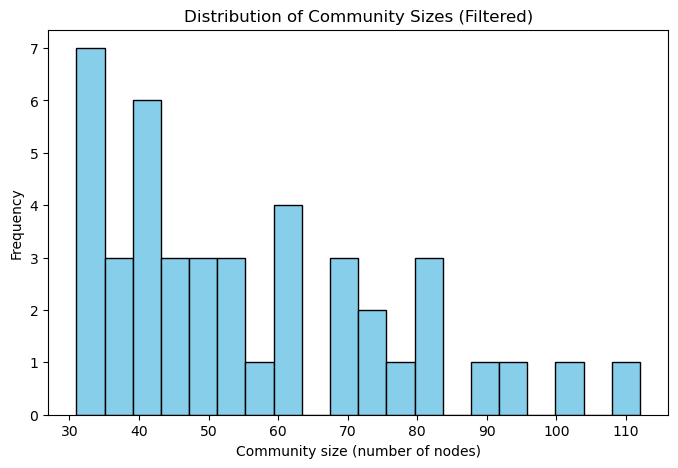

In [150]:
# Get the community label for each vertex in the filtered graph.
# (blocks2 is the vertex property from SBM)
filtered_labels = np.array([blocks2[v] for v in G_filtered.vertices()])

# Compute unique community labels and their sizes.
unique_labels, counts = np.unique(filtered_labels, return_counts=True)

num_communities = len(unique_labels)
min_comm_size = counts.min()
max_comm_size = counts.max()
median_comm_size = np.median(counts)
avg_comm_size = counts.mean()

print("Number of communities in filtered graph:", num_communities)
print("Minimum community size:", min_comm_size)
print("Maximum community size:", max_comm_size)
print("Median community size:", median_comm_size)
print("Average community size:", avg_comm_size)

# Show a histogram of community sizes.
plt.figure(figsize=(8, 5))
plt.hist(counts, bins=20, color="skyblue", edgecolor="k")
plt.xlabel("Community size (number of nodes)")
plt.ylabel("Frequency")
plt.title("Distribution of Community Sizes (Filtered)")
plt.show()

In [151]:
filtered_labels = np.array([blocks2[v] for v in G_filtered.vertices()])
unique_labels, counts = np.unique(filtered_labels, return_counts=True)

# 2. Sort communities by size (descending)
sorted_communities = sorted(zip(unique_labels, counts), key=lambda x: x[1], reverse=True)

print("Communities (label, size) in descending order:")
for label, size in sorted_communities:
    print(f"  Community {label}: size={size}")

Communities (label, size) in descending order:
  Community 172: size=112
  Community 883: size=101
  Community 2159: size=94
  Community 987: size=90
  Community 1878: size=83
  Community 960: size=82
  Community 1047: size=81
  Community 1329: size=77
  Community 918: size=75
  Community 1603: size=74
  Community 736: size=71
  Community 1331: size=69
  Community 2150: size=69
  Community 1607: size=63
  Community 925: size=62
  Community 1376: size=61
  Community 1365: size=60
  Community 196: size=57
  Community 564: size=52
  Community 1172: size=52
  Community 1675: size=52
  Community 2593: size=50
  Community 2925: size=50
  Community 2376: size=48
  Community 738: size=47
  Community 457: size=44
  Community 476: size=44
  Community 1717: size=43
  Community 2476: size=43
  Community 1719: size=42
  Community 253: size=41
  Community 282: size=41
  Community 524: size=40
  Community 2417: size=39
  Community 644: size=37
  Community 1769: size=36
  Community 1106: size=34
  Com

In [36]:
top_k = 1

for i, (comm_label, comm_size) in enumerate(sorted_communities[:top_k], start=1):
    print("========================================")
    print(f"Exploring Community {comm_label} (Rank {i}, size={comm_size})")
    
    # Build a subgraph for this community from G_filtered
    def community_filter(v):
        return blocks2[v] == comm_label
    G_comm = gt.GraphView(G_filtered, vfilt=community_filter)
    print("  Subgraph nodes:", G_comm.num_vertices(), "intraconmmunity edges:", G_comm.num_edges())

    # Extract the original paper IDs from this subgraph
    comm_paper_ids = [int(paper_id_prop[v]) for v in G_comm.vertices()]

    # Subset your DataFrame to these papers
    df_comm = filtered_paper_list.loc[filtered_paper_list.index.isin(comm_paper_ids)]
    print("  Number of papers in DataFrame:", df_comm.shape[0])

    # Inspect some summary stats
    print("  Word count stats: min =", df_comm['word_count'].min(),
          ", max =", df_comm['word_count'].max(),
          ", mean =", df_comm['word_count'].mean())

    # how a few titles or abstracts
    print("\n=========== Sample Abstracts==========")
    print(df_comm['title'].head(5).to_string(index=False))

Exploring Community 172 (Rank 1, size=112)
  Subgraph nodes: 112 intraconmmunity edges: 365
  Number of papers in DataFrame: 112
  Word count stats: min = 41 , max = 348 , mean = 149.0

=========== Sample Abstracts==========
Parameter estimation for rough differential equ...
                                Iterated filtering
Asymptotic properties of {$U$}-processes under ...
Kernel estimators of asymptotic variance for ad...
Consistency of the maximum likelihood estimator...


# Corpus processing

1. remove abstract with less than 20 words and delet correcponding entry in the citation network
2. convert the abstract into BOW(corpus)

Preprocessing steps:

1. tokenize and convert to lowercase
2. lemmatization
3. stop word removal
4. bag-of-word

In [37]:
# Process the abstracts
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
vectorizer = CountVectorizer()

def preprocess_text(text):
    """Tokenizes, lemmatizes, and removes stopwords."""
    words = word_tokenize(text.lower())  # Tokenize and convert to lowercase
    words = [lemmatizer.lemmatize(word) for word in words if word.isalpha() and word not in stop_words]
    return " ".join(words)

# Apply preprocessing to abstracts
filtered_paper_list["processed_abstract"] = filtered_paper_list["abstract"].astype(str).apply(preprocess_text)

# Create Corpus (Bag-of-Words Model)
bow_matrix = vectorizer.fit_transform(filtered_paper_list["processed_abstract"])
corpus = pd.DataFrame(bow_matrix.toarray(), index=filtered_paper_list.index, columns=vectorizer.get_feature_names_out())

/var/folders/0r/kk1hzrmn3gn15tq_k14nb0r00000gn/T/ipykernel_42481/510167351.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_paper_list["processed_abstract"] = filtered_paper_list["abstract"].astype(str).apply(preprocess_text)


In [38]:
print(corpus.shape)

(2408, 9127)


## LDA

In [39]:
from sklearn.decomposition import LatentDirichletAllocation

num_topics = 6
lda_model = LatentDirichletAllocation(n_components=num_topics, random_state = 42)

doc_topic_dist = lda_model.fit_transform(corpus)

# Create a DataFrame for the document-topic distributions
doc_topic_df = pd.DataFrame(
    doc_topic_dist,
    index=filtered_paper_list.index,  # ensure index matches the filtered papers
    columns=[f"Topic_{i}" for i in range(num_topics)]
)

# Build a mapping from paper (node) to its community from the SBM results
# (node_map is the dict mapping from paper index in G2 to graph-tool vertices)
paper_community = {paper_id: blocks2[vertex] for paper_id, vertex in node_map.items()}

# Map each document in filtered_paper_list to its community (if not found, assign NaN)
doc_topic_df['Community'] = filtered_paper_list.index.map(lambda idx: paper_community.get(idx, np.nan))

# Now, compute the average topic distribution for each community
community_topic_dist = doc_topic_df.groupby("Community").mean()

print("Average Topic Distribution per Community:")
print(community_topic_dist)

Average Topic Distribution per Community:
            Topic_0   Topic_1   Topic_2   Topic_3   Topic_4   Topic_5
Community                                                            
172        0.162008  0.655825  0.016890  0.084889  0.031197  0.049192
189        0.243906  0.254843  0.005143  0.050988  0.396578  0.048542
196        0.437586  0.222279  0.013975  0.035957  0.272709  0.017494
253        0.349098  0.413204  0.027300  0.090928  0.062006  0.057463
282        0.341259  0.093225  0.152616  0.300959  0.091307  0.020635
307        0.587303  0.196048  0.008689  0.155401  0.043904  0.008655
342        0.394122  0.342734  0.040806  0.069288  0.116129  0.036921
393        0.113247  0.060952  0.336744  0.341471  0.102652  0.044935
457        0.439194  0.346571  0.017803  0.069555  0.112587  0.014290
476        0.244389  0.159780  0.028366  0.393917  0.111680  0.061869
524        0.290708  0.224442  0.037458  0.118777  0.118856  0.209760
564        0.171909  0.137702  0.179384  0.40459

<Figure size 1200x800 with 0 Axes>

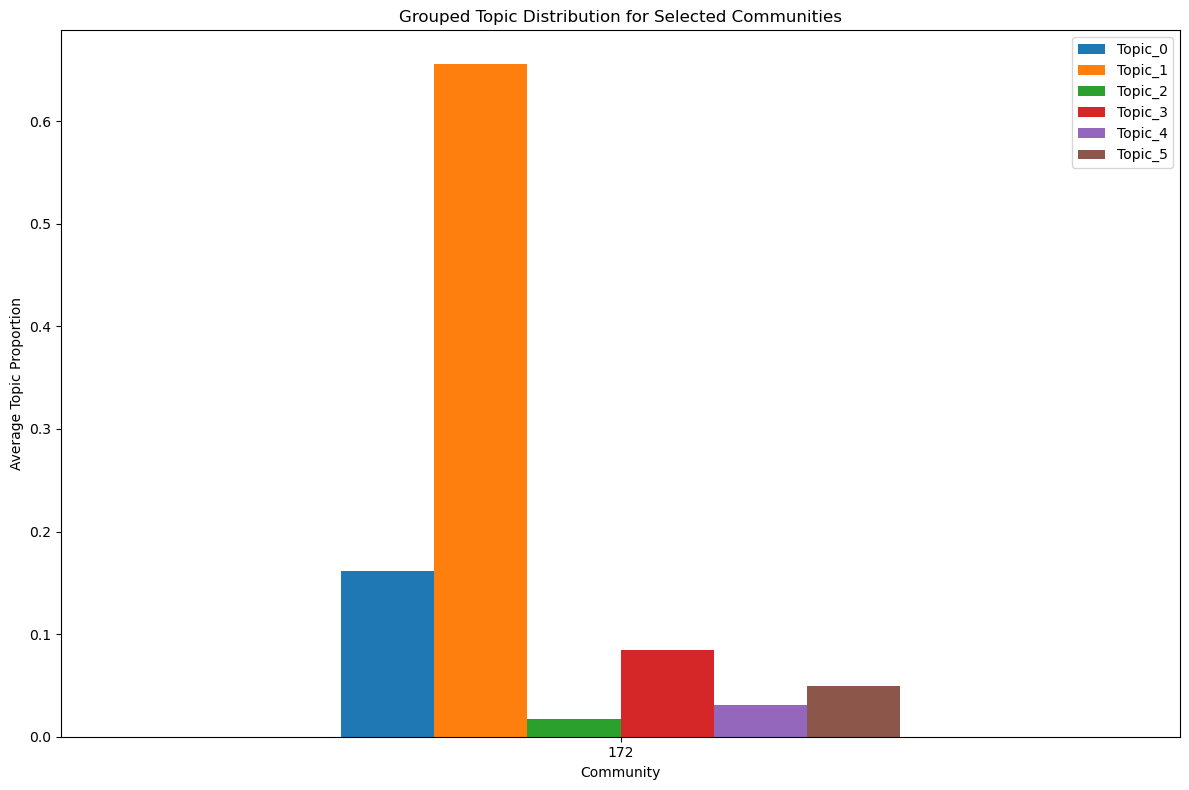

In [40]:
selected_communities = [172]  
selected_data = community_topic_dist.loc[selected_communities]

# Grouped Bar Plot
plt.figure(figsize=(12, 8))
grouped_ax = selected_data.plot(kind='bar', figsize=(12, 8))
grouped_ax.set_title("Grouped Topic Distribution for Selected Communities")
grouped_ax.set_xlabel("Community")
grouped_ax.set_ylabel("Average Topic Proportion")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [42]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        # Get the indices of the top words for this topic
        top_features_ind = topic.argsort()[:-no_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        print(f"Topic {topic_idx}:")
        print("  ", " ".join(top_features))
        
no_top_words = 30
feature_names = vectorizer.get_feature_names_out()
print("\nTop words for each topic:")
display_topics(lda_model, feature_names, no_top_words)


Top words for each topic:
Topic 0:
   estimator model distribution likelihood function method regression asymptotic parameter test data proposed mean estimation simulation sample statistic variance error based time study also result show maximum property estimate linear new
Topic 1:
   model data method distribution approach parameter prior regression bayesian algorithm process selection using estimation posterior based time function analysis variable markov spatial inference problem likelihood also show result new monte
Topic 2:
   design treatment effect optimal two study experiment method factor randomized orthogonal model causal outcome using result also sensitivity one analysis subject criterion network interaction paper randomization property trial factorial minimum
Topic 3:
   data method study model test procedure effect approach analysis hypothesis using proposed rate testing multiple variable sample control false used inference estimate parameter time assumption simulation s

### Inferring the Topics from LDA Model

| **Topic** | **Focus** | **Keywords** |
|-----------|----------|-------------|
| **Topic 0: Classical Statistical Estimation & Asymptotic Theory** | Focus on estimators, asymptotic properties, likelihood methods, and regression models. | `estimator, model, distribution, likelihood, function, method, regression, asymptotic, parameter, test, estimation, simulation, statistic, variance, error, mean, maximum` |
| **Topic 1: Bayesian Methods & Computational Inference** | Bayesian modeling, prior/posterior inference, MCMC, and probabilistic algorithms. | `model, prior, bayesian, posterior, markov, monte, carlo, algorithm, inference, process, distribution, likelihood, estimation, variable` |
| **Topic 2: Experimental Design & Causal Inference** | Experimental setups, randomized trials, treatment effects, and causal inference. | `design, treatment, effect, optimal, experiment, randomized, causal, factor, sensitivity, outcome, interaction, subject, trial, network, orthogonal` |
| **Topic 3: Hypothesis Testing & Statistical Inference** | Classical hypothesis testing procedures, FDR, assumptions, and outcome analysis. | `test, procedure, hypothesis, testing, control, false, variable, inference, sample, outcome, simulation, result, effect, assumption` |
| **Topic 4: Nonparametric Estimation & Functional Data** | Estimation theory, density estimation, Gaussian processes, and functional analysis. | `estimation, density, gaussian, functional, process, class, asymptotic, adaptive, error, matrix, random, mean, case, condition` |
| **Topic 5: Machine Learning Algorithms & Classification** | Prediction models, classification algorithms, convergence rates, and complexity. | `algorithm, classification, classifier, clustering, matrix, vector, prediction, convergence, rate, error, size, bound, statistical, curve` |

## hLDA

In [43]:
import tomotopy as tp

max_depth = 4 

# Create the hLDA model
model_hlda = tp.HLDAModel(depth=max_depth, alpha=1.0, gamma=0.1, eta=0.01, min_cf=5, rm_top=0)

# Create a list to map the order of documents in the hLDA model to your original paper IDs.
doc_mapping = list(filtered_paper_list.index)

# Add documents to the model.
for doc in filtered_paper_list["processed_abstract"]:
    tokens = doc.split()  # our preprocessing already lowercased and removed stopwords/punctuation
    model_hlda.add_doc(tokens)

for i in range(0, 1000, 100): 
    model_hlda.train(100)

In [169]:
model_hlda.summary()


<Basic Info>
| HLDAModel (current version: 0.13.0)
| 2408 docs, 196046 words
| Total Vocabs: 9148, Used Vocabs: 3515
| Entropy of words: 7.03465
| Entropy of term-weighted words: 7.03465
| Removed Vocabs: <NA>
|
<Training Info>
| Iterations: 1000, Burn-in steps: 0
| Optimization Interval: 10
| Log-likelihood per word: -7.08642
|
<Initial Parameters>
| tw: TermWeight.ONE
| min_cf: 5 (minimum collection frequency of words)
| min_df: 0 (minimum document frequency of words)
| rm_top: 0 (the number of top words to be removed)
| depth: 4 (the maximum depth level of hierarchy between 2 ~ 32767)
| alpha: [1.] (hyperparameter of Dirichlet distribution for document-depth level, given as a single `float` in case of symmetric prior and as a list with length `depth` of `float` in case of asymmetric prior.)
| eta: 0.01 (hyperparameter of Dirichlet distribution for topic-word)
| gamma: 0.1 (concentration coeficient of Dirichlet Process)
| seed: 3577711024 (random seed)
| trained in version 0.13.0
|
<

In [172]:
text = """
| #0 (72034, 2408) : model method data approach study
|   #8 (31746, 2265) : result function problem estimator distribution
|     #16 (17815, 1809) : estimator model regression likelihood function
|       #24 (4264, 164) : model process markov chain monte
|       #25 (392, 18) : risk classification aggregation inequality loss
|       #27 (225, 7) : component principal functional analysis data
|       #39 (85, 4) : incidence cohort survival prevalent npmle
|       #49 (132, 4) : robust generalized gam atypical projection
|       #54 (102, 3) : summary statistic posterior adjustment different
|       #66 (104, 4) : selection stability variable regularization estimation
|       #82 (421, 14) : treatment design trial randomization procedure
|       #99 (113, 3) : functional predictor component version pcr
|       #102 (119, 4) : survey item ml health count
|       #112 (124, 2) : treatment interference effect unit one
|       #113 (79, 4) : algorithm smoothing boosting spline l
|       #114 (109, 7) : error measurement regression dependence cocaine
|       #119 (441, 21) : process series trend autoregressive nonstationary
|       #129 (91, 6) : sequence signal q mlqe robust
|       #133 (218, 8) : dimension method reduction predictor x
|       #152 (104, 4) : test statistic matrix ir robust
|       #156 (1095, 57) : test statistic hypothesis null alternative
|       #159 (156, 2) : criterion method selection reml ml
|       #168 (208, 9) : likelihood penalized algorithm penalty function
|       #169 (171, 3) : treatment outcome vaccine randomized event
|       #170 (194, 7) : shape space mean projective k
|       #171 (167, 8) : statist amer assoc soc ser
|       #172 (108, 3) : prior power historical reference general
|       #173 (203, 13) : component time series effect random
|       #179 (326, 18) : covariance matrix spectral cholesky norm
|       #181 (656, 24) : likelihood parameter statistic probability prior
|       #182 (158, 5) : process residual point model earthquake
|       #192 (114, 5) : conditional series stationary process innovation
|       #194 (140, 8) : effect random mixed latent hazard
|       #196 (103, 3) : x p h density class
|       #200 (318, 16) : confidence bound adaptive lower region
|       #202 (374, 18) : process jump volatility test estimator
|       #203 (87, 2) : computer model output functional process
|       #204 (87, 5) : variable selection control selected split
|       #205 (93, 3) : image jump surface smoothing intensity
|       #218 (204, 5) : forecast weather prediction ensemble precipitation
|       #219 (136, 5) : algorithm particle n computational filter
|       #221 (138, 3) : daily temperature price series maximum
|       #222 (158, 6) : marker disease risk accuracy measure
|       #224 (42, 1) : numerical error ode measurement sieve
|       #226 (43, 1) : effect depth core increment carbon
|       #227 (86, 3) : r gamma local component structure
|       #229 (40, 2) : x risk local psi fan
|       #232 (58, 2) : robust selection covariates statistical step
|       #234 (229, 9) : design treatment effect optimal crossover
|       #236 (126, 6) : least absolute stock autoregressive periodogram
|       #238 (184, 6) : learning machine classification support vector
|       #240 (158, 7) : missing estimating weighted weight approach
|       #242 (176, 5) : sampling n rmse carlo order
|       #243 (78, 5) : measure association canonical neuron index
|       #244 (412, 20) : algorithm carlo monte approximation stochastic
|       #245 (195, 6) : perturbation influence measure cook local
|       #246 (144, 6) : tree polya linear bayes distribution
|       #247 (68, 4) : tree data design complex imputation
|       #259 (337, 19) : spatial process point approach intensity
|       #260 (182, 5) : copy number rate region dna
|       #262 (133, 4) : election vote night use evidence
|       #263 (73, 3) : n mean proportion estimating oracle
|       #272 (265, 9) : f density estimator x n
|       #274 (384, 12) : lasso p n theta sparse
|       #275 (161, 4) : change theta sequential markov detection
|       #277 (274, 10) : test hypothesis null prior alternative
|       #278 (96, 2) : rate measure surveillance county survival
|       #279 (86, 4) : anova local decomposition criterion partial
|       #281 (135, 8) : covariance model function time origin
|       #284 (180, 2) : model deconvolution discrete convergence rate
|       #286 (109, 3) : smoothing spatial pattern spline voronoi
|       #287 (209, 5) : sample pca matrix n p
|       #288 (74, 3) : forecast loss growth optimality period
|       #290 (40, 1) : z imputation category probability small
|       #292 (121, 4) : variable lasso x design sparse
|       #293 (171, 6) : time signal functional source point
|       #294 (184, 10) : binary matrix correlation estimating equation
|       #295 (113, 4) : exposure design risk study cancer
|       #305 (165, 5) : test trait multiple factor covariates
|       #307 (86, 5) : equivalence alpha experiment design established
|       #310 (194, 6) : nonresponse response covariates variable survey
|       #311 (84, 5) : error transformation nonparametric value spaced
|       #312 (81, 2) : noise image regression component statistic
|       #313 (82, 2) : individual causal effect outcome group
|       #314 (420, 16) : prediction model error mixed small
|       #315 (263, 12) : imputation multiple variance missing general
|       #316 (60, 2) : screening predictor fr independence sure
|       #317 (232, 10) : dependence extreme spatial multivariate process
|       #318 (306, 10) : causal effect outcome treatment principal
|       #319 (117, 5) : confidence interval bound ml component
|       #321 (131, 4) : estimate size network population american
|       #324 (546, 28) : time data failure bivariate risk
|       #325 (281, 11) : markov state model probability hidden
|       #326 (397, 18) : sampling design estimator variance sample
|       #327 (153, 8) : wavelet shrinkage basis coefficient method
|       #336 (210, 13) : missing data covariate covariates response
|       #339 (622, 25) : regression dimension reduction predictor inverse
|       #340 (301, 15) : interval confidence probability coverage prediction
|       #341 (402, 16) : selection oracle variable criterion estimator
|       #342 (84, 2) : call center rate service customer
|       #343 (155, 5) : covariance structure mean correlation parameter
|       #344 (74, 2) : z x e quantity variation
|       #349 (145, 6) : estimator survey area information sampling
|       #352 (108, 4) : sampling variance systematic error importance
|       #353 (32, 1) : spike train pattern depends template
|       #354 (173, 9) : spline regression polynomial penalty knot
|       #356 (224, 7) : exposure outcome interaction confounders effect
|       #357 (111, 5) : input simulator output computer system
|       #358 (89, 3) : distribution x residual multinomial outcome
|       #368 (132, 11) : process limit theorem central linear
|       #369 (234, 10) : additive component model regression quantile
|       #370 (220, 10) : estimating correlation equation working matrix
|       #372 (132, 3) : develop integral diffusion curve hypothesis
|       #373 (163, 9) : local bandwidth polynomial estimate quantile
|       #377 (144, 5) : class outcome mean model vector
|       #378 (68, 2) : process branching cell emigration offspring
|       #379 (271, 11) : event time recurrent censoring process
|       #380 (89, 2) : donor factor center transplant graft
|       #384 (207, 8) : curve function warping functional component
|       #385 (315, 13) : design criterion factor optimal aberration
|       #386 (127, 3) : functional function effect curve lpk
|       #387 (186, 5) : care service health patient charge
|       #389 (221, 9) : method central dimension predictor subspace
|       #391 (145, 8) : effect variable treatment structural instrumental
|       #401 (294, 12) : distribution family likelihood normal multivariate
|       #402 (121, 6) : variable correlation selection partial covariates
|       #403 (247, 7) : spatial covariance likelihood data set
|       #407 (312, 15) : thresholding estimator procedure wavelet adaptive
|       #408 (86, 3) : sampling adhesion frequency rate design
|       #409 (162, 4) : covariates treatment outcome assumption distribution
|       #410 (83, 2) : sampling x distribution p random
|       #411 (138, 7) : diffusion process stochastic mle carlo
|       #412 (341, 15) : bootstrap interval confidence coverage n
|       #414 (147, 4) : data multiscale spatial adaptive regression
|       #415 (282, 15) : posterior distribution prior bayesian regression
|       #416 (681, 25) : false hypothesis discovery procedure test
|       #418 (203, 5) : matrix rank low rsc error
|       #421 (57, 2) : region design proposed thermal adaptive
|       #423 (94, 4) : robust trimming trimmed initial mstle
|       #424 (168, 6) : bootstrap component vector principal rank
|       #425 (263, 9) : prior bayes factor model class
|       #426 (96, 3) : experiment randomization decomposition structure relationship
|       #428 (62, 1) : mean depth trimmed robustness well
|       #431 (144, 7) : estimator function nonparametric rate mle
|       #433 (233, 8) : estimator probability outcome auxiliary missing
|       #435 (150, 3) : density error regression conditional predictor
|       #436 (88, 3) : distribution class elliptical mechanism introduce
|       #439 (318, 13) : model censoring survival life residual
|       #440 (201, 2) : procedure multiple false endpoint vector
|       #441 (135, 4) : cluster algorithm clustering number eigenvectors
|       #442 (123, 3) : procedure testing multiple principle equivalence
|       #443 (273, 10) : bootstrap block time series domain
|       #445 (63, 2) : event primary endpoint trial clinical
|       #446 (241, 6) : smoothing model generalized spline additive
|       #447 (225, 6) : x z f k vertical
|       #449 (128, 6) : model design ld logistic nonlinear
|       #451 (154, 9) : risk procedure extreme estimate performance
|       #453 (69, 3) : confidence set volume using radius
|       #454 (554, 19) : graph model matrix independence graphical
|       #455 (75, 3) : calibration sharpness predictive probabilistic forecast
|       #456 (92, 4) : entropy divergence design maximum minimizing
|       #457 (93, 6) : band confidence curve spline comparison
|       #458 (91, 6) : field spherical random connection testing
|       #459 (135, 5) : hazard curve assumption residual survival
|       #460 (64, 3) : multimodality mode bootstrap excess unrelated
|       #462 (278, 11) : discovery procedure null testing false
|       #464 (96, 5) : expansion edgeworth power n series
|       #467 (356, 17) : process prior bayesian dirichlet posterior
|       #471 (197, 9) : process garch test paper residual
|       #474 (68, 3) : survival best patient periodontal prognostic
|       #475 (109, 3) : regression sample covariates auxiliary effect
|       #478 (31, 1) : correlated sample moment panel negligible
|       #479 (63, 2) : likelihood adjusted robust fails evidence
|       #483 (117, 4) : network problem algorithm beam inverse
|       #485 (153, 9) : boundary image convolution body surface
|       #492 (156, 5) : event mark marginal time hazard
|       #494 (159, 4) : likelihood ratio null hypothesis statistic
|       #495 (214, 10) : value threshold extreme cluster tail
|       #496 (150, 4) : gene shrinkage expression bayesian differential
|       #497 (214, 6) : survey population variable information auxiliary
|       #498 (153, 5) : treatment time formula trial response
|       #499 (115, 7) : estimating inference equation function robustness
|       #500 (134, 5) : assumption car data observed distribution
|       #501 (128, 5) : spatial block region image subsampling
|       #502 (138, 6) : algorithm estimate likelihood maximum convergence
|       #503 (336, 17) : criterion information selection model bayesian
|       #505 (112, 5) : density joint conditional dependence observation
|       #508 (75, 3) : model stochastic network experimental mutation
|       #509 (154, 4) : matrix sample covariance approach eigenvalue
|       #511 (242, 7) : model selection combining optimal bayesian
|       #516 (252, 14) : quantile error covariate censored covariates
|       #518 (60, 2) : degree freedom estimate square partial
|       #521 (117, 5) : additive backfitting regression estimator sbe
|       #523 (295, 11) : mixture component criterion finite information
|       #527 (62, 1) : g le f estimator consistent
|       #528 (96, 3) : theta inference model beta parameter
|       #530 (97, 4) : linkage parameter probability lung two
|       #532 (53, 1) : q criterion information tilde em
|       #534 (169, 7) : series time autoregressive estimate innovation
|       #535 (29, 1) : hough transform line convergence excess
|       #537 (867, 41) : prior bayesian distribution posterior model
|       #541 (139, 3) : condition posterior distribution improper prior
|       #543 (54, 3) : deviation moderate large risk delta
|       #547 (134, 6) : estimator bandwidth kernel copula value
|       #549 (51, 3) : error underestimation overestimation exponent b
|       #554 (224, 10) : lambda process vertical bar infinity
|       #555 (68, 3) : estimator zero coefficient wavelet reduced
|       #559 (112, 4) : procedure ranking test perfect sample
|       #563 (48, 2) : survival problem integrand integral always
|       #567 (44, 2) : difference expenditure sample ratio mean
|       #568 (59, 3) : regularization functional part problem focus
|       #572 (89, 3) : profile sampler posterior semiparametric set
|       #574 (160, 6) : interval test confidence nominal coverage
|       #585 (87, 4) : density mixture theta covariates discrete
|       #588 (177, 5) : linkage score locus trait genetic
|       #593 (63, 4) : problem calibration levy functional l
|       #596 (116, 5) : standard error score measurement simex
|       #597 (102, 4) : cluster effect size random marginal
|       #598 (644, 35) : time series test process spectral
|       #600 (55, 4) : frailty variance relative gamma shared
|       #603 (157, 8) : model table test class ml
|       #605 (87, 6) : rank pairwise lifetime censoring independent
|       #614 (110, 5) : quantile estimation location conditional garch
|       #619 (63, 2) : functional measurement curve observation vector
|       #620 (91, 5) : empirical likelihood problem missing statistical
|       #621 (55, 1) : n cap theta c x
|       #632 (48, 3) : rule gamma difference precision misclassification
|       #633 (88, 3) : observed process diffusion observation time
|       #638 (65, 2) : modeling general covariate odds doubly
|       #639 (201, 10) : time series prediction interval seasonal
|       #644 (66, 3) : h validation cross lm otherwise
|       #646 (120, 7) : constrained factor constraint estimation measure
|       #648 (30, 2) : bayesian multivariate frequentist manifold keep
|       #650 (71, 3) : parameter dropout longitudinal random shared
|       #652 (110, 3) : approach combining information confidence distribution
|       #653 (39, 3) : network neural ridge larger critical
|       #656 (240, 7) : algorithm monte carlo sequential resampling
|       #657 (227, 9) : volatility time process interval financial
|       #659 (35, 2) : quantum hyperbolic plane state system
|       #666 (39, 2) : k gap spline tau knot
|       #672 (65, 3) : envelope model efficiency generalised gain
|       #677 (75, 3) : network structure node fit weighted
|       #678 (61, 2) : n el c data structure
|       #685 (67, 3) : shift test proportion heterogeneous gene
|       #691 (85, 3) : f cap n k g
|     #17 (117, 18) : bound lower learning derived criterion
|       #48 (57, 2) : expected treatment p confidence allocation
|       #283 (62, 2) : group lasso prediction establish sparsity
|       #383 (190, 8) : design array orthogonal e supersaturated
|       #461 (103, 5) : rate classifier risk noise bagging
|       #539 (50, 1) : frequency ar ifa estimation must
|     #19 (75, 8) : difference large support machine class
|       #382 (50, 1) : absorber line rigid catalog estimator
|       #491 (141, 7) : classifier vector classification scale performance
|     #20 (68, 7) : pricing price state learning option
|       #207 (29, 1) : bond company term credit management
|       #486 (46, 2) : fence strategy prediction set probability
|       #504 (35, 3) : quantile growth contour bivariate chart
|       #587 (38, 1) : tree classification sequential online dynamic
|     #40 (2, 3) : orthogonal relationship data estimator distribution
|       #256 (94, 2) : cointegrating vector subspace matrix fractional
|       #675 (37, 1) : residual filtered procedure innovation predicted
|     #41 (35, 2) : n ape delta asymptotic obtained
|       #38 (79, 2) : prediction error criterion model ar
|     #47 (72, 7) : test lagrange power expansion al
|       #465 (180, 5) : mu n q vector sparse
|       #561 (88, 2) : heart rate recovery risk exercise
|     #73 (49, 3) : partitioning optimal methodology phase outcome
|       #70 (97, 2) : placebo profile subject clinical drug
|       #417 (77, 1) : theta psi likelihood determination parameter
|     #75 (119, 8) : motif clustering several cluster factor
|       #117 (153, 3) : prior model c facet graphical
|       #404 (20, 1) : clustering significance gaussian fundamental hdl
|       #487 (87, 4) : pattern problem sequence protein dna
|     #88 (56, 4) : skill player whether period evidence
|       #405 (32, 1) : time service density explicit might
|       #564 (146, 3) : model climate analysis different distribution
|     #90 (85, 9) : statistic scan window n p
|       #225 (71, 2) : filtering median linear snr framework
|       #429 (75, 2) : cluster location signal testing unit
|       #434 (215, 5) : gene expression microarray image intensity
|     #91 (46, 3) : rate pedestrian police group department
|       #98 (80, 2) : stop racial traffic race profiling
|       #390 (44, 1) : sed school scale individual score
|     #120 (87, 10) : score propensity bias observational exposure
|       #128 (42, 1) : missing confounders data validation summary
|       #573 (84, 4) : system process equation dynamical noisy
|       #610 (82, 2) : matching control full group treated
|       #649 (71, 3) : parameter nuisance estimating sequential function
|     #123 (7, 4) : marginal contemporary ideal stationary particular
|       #130 (48, 1) : type g limit integral represented
|       #135 (67, 1) : wavelet spectrum group signal evolutionary
|       #216 (83, 2) : conditional approach likelihood mixing equivalence
|     #124 (40, 1) : degree freedom denominator currently size
|       #645 (4, 1) : equal performing derived estimator distribution
|     #126 (92, 5) : survey estimator domain small precision
|       #28 (97, 3) : area estimate census direct within
|       #31 (40, 1) : algorithm variance replicates important stratum
|       #80 (22, 1) : autoregressions corresponding de intrinsic variogram
|     #127 (133, 9) : group brain structure subject spatial
|       #183 (48, 2) : correlation spatiotemporal activity temporal processing
|       #261 (32, 1) : block sensitivity syndrome x count
|       #608 (15, 1) : blur accomplished unrealistic growing extent
|       #658 (93, 3) : group testing individual procedure retesting
|       #684 (29, 2) : variability bagging pcr reduced crossvalidation
|     #146 (137, 12) : matrix covariance eigenvalue population principal
|       #241 (104, 3) : variable latent manifest gfi test
|       #280 (78, 1) : symptom mother infant cough three
|       #282 (3, 1) : try inspired pca estimator distribution
|       #371 (52, 2) : linear forecast probability calibrated pooling
|       #529 (27, 2) : law p limiting largest coherence
|       #618 (28, 1) : ax similarity across pair heterogeneity
|       #628 (39, 2) : estimator compute cluster sufficient g
|     #147 (131, 15) : principal component analysis sphere pca
|       #484 (178, 8) : shape space geodesic path landmark
|       #525 (121, 5) : density kernel bandwidth well mode
|       #699 (88, 2) : ranking institution attribute even true
|     #149 (54, 5) : local reduction global embedding construct
|       #198 (108, 1) : coefficient national mortality pollution time
|       #199 (149, 3) : slex time series discrimination feature
|       #438 (7, 1) : force agree measuring pca pointwise
|     #151 (56, 3) : tissue type voxel voxels homogeneous
|       #493 (31, 1) : definition breakdown region critical configuration
|       #686 (70, 2) : regression prior smooth variable activation
|     #160 (31, 2) : sampling efficient state sampler facilitates
|       #682 (34, 2) : multiscale spatiotemporal dynamic nested geographical
|     #161 (361, 17) : control false rejection one discovery
|       #235 (431, 14) : procedure hypothesis null rate test
|       #291 (46, 1) : matched subject dose error exposed
|       #647 (113, 2) : project problem utility chain phase
|     #162 (72, 3) : algorithm operational misr pixel surface
|       #562 (91, 3) : climate temperature time space record
|     #165 (258, 7) : depth estimator function projection scatter
|       #480 (127, 7) : robustness location contamination property uniform
|     #167 (112, 4) : balance subject one matched match
|       #201 (24, 1) : rectangular normalization across array financial
|       #289 (82, 3) : treatment effect randomization covariate ballot
|     #184 (118, 7) : boosting algorithm margin classifier adaboost
|       #427 (80, 4) : l regression path problem kqr
|       #482 (35, 3) : convergence function stopping result left
|     #189 (124, 5) : mu x bar vertical bayes
|       #273 (47, 1) : family standard conjugate sigma enriched
|       #476 (62, 3) : cardinality invariant similar scale many
|       #477 (27, 1) : empirical bayes formula bias z
|     #210 (19, 2) : modelling restriction incomplete identifying sufficiently
|       #660 (65, 2) : mnar observed missingness random outcome
|     #211 (110, 12) : approximation saddlepoint random density variable
|       #468 (111, 4) : treatment regime component optimal dynamic
|       #515 (49, 2) : normalising constant joint computation subset
|       #655 (82, 5) : direction projection outlier vector multivariate
|       #664 (9, 1) : obtained loglikelihood canonical reparameterization et
|     #212 (66, 4) : proposal mode prior approximation algorithm
|       #53 (14, 1) : signature curvature built verification template
|       #413 (68, 2) : sampling slice distribution uniform variable
|       #570 (37, 1) : label sample labeling posterior pm
|     #213 (86, 10) : function loss binary class covariate
|       #50 (61, 3) : algorithm prediction hypothesis error adaboost
|       #67 (18, 1) : random disease clustered straightforward aggregation
|       #374 (62, 1) : status organ level patient health
|       #452 (74, 3) : normal cluster variable sensor testing
|       #506 (36, 1) : covariates dimension nonconvex quantile optimality
|       #607 (38, 1) : gibbs sampler convergence statistical complex
|     #215 (72, 4) : spatial curve surface point boundary
|       #606 (7, 1) : changing decreasing specie appropriately objective
|       #695 (60, 3) : field general matern coefficient gaussian
|     #248 (49, 2) : question world record event ultimate
|       #623 (52, 2) : almost sure regression binary answer
|     #250 (62, 3) : phase cell cycle gene angle
|       #643 (49, 3) : algorithm sampling langevin step initial
|     #251 (12, 2) : el justify posteriori extent following
|       #178 (18, 1) : periodogram nonparametric aspect drawback user
|       #322 (12, 1) : bayesian discrepancy map misspecification demonstrating
|     #252 (76, 4) : clustering spectral network eigenvectors graph
|       #513 (86, 4) : matrix random sensing kernel signal
|     #253 (75, 3) : data agency disclosure sampling census
|       #481 (70, 3) : risk identification record microdata little
|     #254 (12, 3) : ideally admits northwest honest respective
|       #51 (60, 1) : component smoothing x relevant irrelevant
|       #175 (175, 2) : scoring function rule score proper
|     #255 (70, 7) : quantum measurement bound state probability
|       #348 (150, 5) : test hypothesis testing significance mean
|       #663 (43, 2) : inequality adaptive minimax characteristic oracle
|     #265 (6, 3) : conceptual perhaps separation hybrid determined
|       #97 (69, 2) : curve clustering prior set mixture
|       #595 (40, 1) : value binomial training poisson k
|     #267 (51, 4) : contaminant water joint regulatory distribution
|       #86 (100, 2) : pollen abundance spatial feature taxon
|       #565 (89, 2) : prior selection sign regression prediction
|     #268 (92, 11) : procedure hypothesis testing shown multiple
|       #233 (41, 1) : bootstrap ar differencing power root
|       #422 (147, 3) : test method k general stepdown
|       #517 (29, 1) : cholesterol pulmonary function relationship total
|       #591 (50, 2) : minimax quadratic functional estimating sharp
|       #627 (46, 2) : lpd separate delta omega classifier
|       #629 (36, 2) : bandwidth version indirect hall aimed
|     #269 (231, 12) : procedure control fdr rate false
|       #347 (37, 3) : vector region confidence resampled principle
|       #542 (72, 3) : parameter selected bayesian ci selection
|       #569 (26, 1) : individual existing sidak receiver generation
|       #630 (45, 2) : curve fdr new rejection conservative
|       #669 (45, 3) : constraint attain among latent independent
|     #271 (113, 12) : treatment trial clinical patient arm
|       #118 (37, 1) : treatment rule individualized response due
|       #132 (101, 2) : stroke measure r agreement scale
|       #306 (55, 3) : probability event forecast occurrence positive
|       #469 (105, 5) : procedure sequential sequentially test design
|       #584 (39, 1) : estimator submodels weighted structure implication
|     #298 (351, 22) : hypothesis testing test false multiple
|       #35 (67, 1) : pattern vertical bar subset cap
|       #223 (33, 1) : response permutation marker genetic association
|       #231 (39, 1) : early intervention latter p technique
|       #276 (139, 7) : fdr procedure significance fixed positive
|       #466 (42, 3) : group statistic us profile temporal
|       #550 (141, 4) : time series dependence functional change
|       #641 (66, 2) : endpoint decision path making drug
|       #680 (71, 3) : confidence estimate interval transmission vaccination
|     #299 (88, 11) : new depth curve functional observation
|       #154 (30, 1) : classifier device cancer greatest molecular
|       #158 (30, 2) : h point stationary e conditional
|       #195 (87, 2) : diagnostic test verification auc gold
|       #230 (53, 1) : bankruptcy regression predictor stepwise prediction
|       #309 (114, 2) : estimator h mean adaptive candidate
|       #381 (54, 2) : growth class trajectory mixture residual
|       #388 (42, 1) : analysis object data space population
|     #300 (76, 10) : balanced method variable sampling sample
|       #463 (74, 3) : weighted measure l weighting unweighted
|       #538 (67, 2) : random algorithm imputation field pixel
|       #589 (29, 1) : pearson power biometrika admissible nonnegative
|       #640 (27, 1) : prior g mixture formulation default
|       #670 (79, 3) : screening correlation variable number treatment
|     #301 (151, 7) : treatment outcome score propensity potential
|       #83 (82, 1) : cancer prostate finasteride difference due
|       #197 (59, 1) : experiment participant randomized adjustment study
|       #338 (34, 2) : inverse probability weighted precision improvement
|       #473 (122, 3) : model structural effect exposure observed
|     #303 (180, 16) : design optimal balanced allocation experiment
|       #155 (13, 1) : component nested canonical row smallest
|       #180 (114, 2) : r stage arm patient trial
|       #220 (62, 3) : power bandwidth term expansion normal
|       #239 (26, 1) : sampling functional obtain electricity band
|       #432 (25, 1) : fit regression lack polynomial practically
|       #472 (40, 2) : hypercube approximation average latin sample
|       #536 (123, 2) : hypothesis sensitivity observational effect treatment
|       #612 (86, 2) : potential outcome causal intermediate fisher
|       #683 (64, 2) : anova mean variance analysis dimension
|     #328 (61, 5) : attitude response mum style statement
|       #661 (34, 2) : significance run length understand net
|       #662 (67, 2) : data array death linear multidimensional
|       #689 (23, 1) : survival capture abundance animal side
|     #329 (47, 6) : group grouped cap predictor including
|       #308 (14, 1) : around search subsample affine discrepancy
|       #350 (97, 3) : grouping penalty regularization performance predictive
|       #355 (44, 2) : biological pathway protein hormone mu
|     #331 (52, 6) : spatial datasets missing spaced even
|       #116 (66, 3) : class new predictor member orientation
|       #673 (132, 3) : n cluster value process block
|     #332 (62, 3) : distribution expert elicited statement task
|       #81 (44, 1) : count network reference p quickly
|       #690 (61, 2) : elicitation opinion prior family question
|     #333 (139, 9) : interaction exposure cause sufficient misclassification
|       #470 (55, 3) : mixture p k item block
|       #540 (114, 6) : causal bound effect response dag
|     #334 (88, 7) : multivariate process condition set shift
|       #30 (45, 1) : mu j vertex path graph
|       #96 (47, 1) : copula archimedean generator shown kendall
|       #177 (47, 1) : npc diffusion constraint smoothness variation
|       #514 (43, 1) : sampling signal level high wavelet
|       #609 (58, 3) : linear combination regression exponential screening
|     #335 (20, 2) : urn imu beneficial importantly yielding
|       #522 (89, 2) : test treatment aberrant trial response
|     #360 (74, 7) : thresholding matrix covariance generalized sparsity
|       #556 (23, 1) : graphical category structure common inverse
|       #626 (74, 2) : order sampling technique spatially basic
|       #665 (66, 4) : p mu norm sigma defined
|     #361 (187, 13) : causal variable effect directed acyclic
|       #217 (45, 2) : confounding distortion explanatory process shown
|       #237 (54, 1) : point end surrogate ace treatment
|       #533 (52, 1) : treatment iv covariates observed instrument
|       #560 (51, 2) : test observation change sequence idea
|       #571 (60, 2) : covariates selection control effect plan
|       #622 (93, 5) : graph node neighborhood p testing
|     #364 (112, 7) : coefficient regression selector dantzig lasso
|       #228 (28, 1) : lars correlation robust outlier candidate
|       #285 (68, 4) : alpha design processing step p
|       #531 (53, 2) : beta estimate x region accurate
|     #367 (88, 6) : structure chromosome expression gene correlation
|       #176 (37, 1) : pathway component latent sparse investigate
|       #545 (94, 3) : graph amp cg essential selection
|       #634 (78, 2) : snp haplotype adjustment disease association
|     #392 (6, 2) : joint mse scatter expressed property
|       #546 (123, 2) : ax rotation mean ankle frechet
|     #394 (40, 4) : term maker structure rate interest
|       #32 (57, 2) : model forecast dynamic economic provides
|       #642 (102, 2) : ozone trend level site temporal
|     #395 (30, 3) : segment detecting number copy snp
|       #323 (63, 2) : variant signal identifying present noise
|       #592 (25, 1) : dependence feature shared variation scenario
|     #396 (55, 7) : independent special transformation theoretical independence
|       #65 (66, 1) : antithetic coupling carlo monte k
|       #359 (46, 2) : depth mobius introduced plane projection
|       #376 (87, 2) : state particle filter sample current
|       #654 (62, 2) : test random sensitivity imperfect specificity
|     #398 (156, 13) : variable predictor forest prediction procedure
|       #29 (44, 1) : level power resolution individual cluster
|       #34 (53, 1) : score importance efficacy earth infinity
|       #37 (69, 1) : exposure inference assumption instrumental approximate
|       #420 (74, 2) : region spacing tolerance depth order
|       #490 (104, 3) : functional component principal analysis sample
|       #512 (142, 3) : treatment effect sensitivity bias design
|       #526 (37, 1) : process spatial location continuous domain
|       #553 (67, 1) : process condition morphology different synthesis
|     #576 (161, 11) : distribution parameter posterior bayesian data
|       #26 (43, 1) : available nonidentified via limit informative
|       #36 (54, 1) : yield factor tau month curve
|       #85 (43, 1) : smoothing disease periodontal different loss
|       #375 (34, 2) : representation network expectation multimodal domain
|       #400 (96, 1) : locus population among st rate
|       #437 (72, 1) : index census variable material level
|       #594 (27, 2) : diagnostics essentially formula broad upon
|       #615 (55, 2) : inconsistency evidence source consistency f
|   #9 (107, 2) : vertical bar x augmentation wu
|     #18 (11, 2) : assoc stat effort meng ann
|       #488 (99, 2) : algorithm k da operator parallel
|   #10 (32, 1) : tensor eigenvalue noise diffusion establishing
|     #76 (1, 1) : tissue method data estimator distribution
|       #134 (31, 1) : eigenvectors theoretical image healthy orientation
|   #11 (166, 6) : n f p x let
|     #21 (83, 3) : lambda r epsilon sigma j
|       #637 (20, 3) : involve theta taking wishart entropy
|     #187 (114, 3) : vaccine effect causal bias postinfection
|       #671 (104, 3) : analysis sensitivity prior assumption inference
|   #12 (370, 18) : design aberration minimum factor factorial
|     #22 (131, 12) : n run projection pattern doubling
|       #33 (144, 9) : resolution iv nonregular shown constructed
|       #345 (31, 1) : sequential process activity financial investigation
|       #674 (29, 2) : indicator function uniformity used effective
|     #188 (17, 6) : ho considered independence statistically formulated
|       #193 (57, 4) : interaction robust orthogonal clear array
|       #548 (149, 2) : treatment test assignment assumption evidence
|   #13 (101, 4) : parameter family inference markov mcmc
|     #92 (107, 2) : beetle pine red tree colonization
|       #651 (51, 2) : exponential discrete model statistical unstable
|     #122 (2, 1) : verifying block data estimator distribution
|       #346 (47, 1) : inclusion spherical obtained ellipsoidal extreme
|     #264 (110, 1) : wishart shape type g hyper
|       #616 (6, 1) : every computing thus fixed present
|   #14 (62, 5) : seasonal year spatial departure air
|     #121 (6, 2) : concentration pronounced dynamic state linear
|       #544 (12, 1) : develop train validate optimum goodness
|       #586 (35, 1) : relationship importance pathway empirical loss
|     #185 (4, 1) : expansion environment exhibit estimator distribution
|       #557 (39, 1) : nonstationary field dimension following plane
|     #366 (35, 2) : wildfire index contribution predicting assessment
|       #636 (33, 2) : bi survival rate management impact
|   #15 (113, 5) : process sum partial distribution residual
|     #43 (59, 5) : change statistic changepoint test cyclone
|       #52 (166, 5) : chart shift control cusum mean
|   #56 (133, 11) : nested computer property construct experiment
|     #45 (219, 11) : design latin method hypercube constructing
|       #64 (77, 5) : orthogonal construction block class main
|       #448 (79, 6) : orthogonal hypercubes large small result
|   #57 (57, 1) : portfolio workload effect capacity problem
|     #77 (4, 1) : guaranteed always simultaneously applied distribution
|       #206 (21, 1) : risk optimization planning shared environment
|   #58 (114, 8) : data health source bias imputation
|     #94 (37, 2) : experiment sequencing dna background technology
|       #604 (59, 2) : state target search people attention
|     #296 (85, 2) : standard race census count error
|       #257 (44, 2) : mutation mm collected group disease
|     #397 (105, 4) : survey nhis telephone brfss cancer
|       #55 (34, 2) : income year family earnings area
|       #153 (52, 1) : exposure concentration average various pm
|       #507 (37, 1) : chemotherapy treatment underreporting true reporting
|   #59 (33, 3) : interference two great social credible
|     #163 (73, 3) : surrogate effect end point true
|       #668 (109, 3) : treatment study subject interest effect
|   #60 (37, 1) : f r domain connected dense
|     #44 (10, 1) : subset omega invertible smoothed uniformly
|       #131 (30, 1) : random u field z simply
|   #61 (66, 2) : eds progression time survival curve
|     #330 (20, 2) : scheme smc path backward physic
|       #635 (23, 2) : observation resampling diffusion bridge forward
|   #62 (287, 11) : treatment randomized effect study intervention
|     #23 (40, 3) : episode length time recurrent event
|       #575 (64, 1) : breastfeeding decision rule growth response
|       #624 (35, 2) : asthma missing mechanism life program
|     #95 (70, 1) : iv test sensitivity overidentifying validity
|       #625 (5, 1) : violation examines direction provided outcome
|     #191 (79, 4) : analysis enalapril assignment significant placebo
|       #337 (64, 3) : gerber green fisher century neyman
|       #510 (40, 1) : aspirin pravastatin combination considered fda
|     #362 (45, 3) : pcp assumption latent context estimand
|       #558 (24, 2) : guideline primary physician meet treating
|       #613 (33, 1) : design preference woman hybrid score
|   #63 (124, 12) : data function profile bayesian posterior
|     #42 (48, 3) : count beta boston harbor near
|       #84 (75, 1) : strip point alpha anisotropy curve
|       #696 (77, 2) : treatment psa covariates patient prediction
|     #74 (55, 5) : pathogen transmission missing observed disease
|       #304 (58, 3) : infection contact individual rate virus
|       #520 (27, 1) : activity child case incomplete functional
|       #552 (67, 1) : patient ability response model different
|     #144 (4, 2) : harbor pooled breast learning distribution
|       #519 (71, 2) : genomic available copy loss tumor
|     #302 (35, 2) : willingness survey public expert loss
|       #258 (61, 1) : impact future mitigate cost climate
|       #688 (4, 1) : thermal layer obvious change distribution
|   #104 (155, 4) : wind power forecast speed direction
|     #214 (34, 4) : prediction center upon predictive treating
|       #601 (38, 2) : accurate regime meteorological site spatial
|       #679 (66, 2) : system behavior cooling within useful
|   #105 (25, 1) : officer false police methodology york
|     #78 (3, 1) : rate rigorously data estimator distribution
|       #71 (24, 1) : potential flag department risk city
|   #106 (38, 1) : channel current density single recording
|     #125 (17, 1) : electrophysiological silverman gained place background
|       #430 (16, 1) : protein mode test drug characterized
|   #108 (115, 4) : retailer traditional purchase sale distribution
|     #148 (93, 4) : wage effect program trained people
|       #524 (37, 3) : decision firm subsequent event offering
|       #676 (24, 1) : control california synthetic aggregate comparative
|   #109 (123, 3) : closure bias factor philadelphia mother
|     #150 (40, 3) : effect sensitivity ii earnings insensitive
|       #351 (16, 1) : unmeasured pair focused planning claim
|       #419 (137, 2) : instrument treatment random encouragement assignment
|   #110 (3, 2) : law transformation density estimator distribution
|     #164 (94, 2) : relationship within nhanes household ratio
|       #444 (19, 1) : sensitive however dna member agree
|       #450 (77, 1) : bmi selection nonresponse race sex
|   #136 (71, 4) : treatment group percentile control stochastic
|     #145 (113, 4) : research prevention disease trial method
|       #320 (35, 4) : review robbins development approximation paper
|   #137 (84, 12) : time bayesian hierarchical dirichlet uncertainty
|     #46 (67, 6) : clustering sequence mixture computing object
|       #406 (2, 1) : sieve method data estimator distribution
|       #489 (39, 1) : crisis cause fast system intervention
|       #590 (22, 1) : income volatility prior dynamic panel
|       #611 (69, 2) : gene cluster expression motif testing
|       #692 (70, 1) : mapping functional longitudinal coefficient local
|     #93 (150, 4) : cancer rate joinpoints incidence joinpoint
|       #69 (37, 1) : cure class cured modeling reveal
|       #115 (56, 1) : control ntp test historical animal
|       #174 (80, 2) : model delay seer registry reporting
|     #190 (85, 2) : effect greenhouse solar global radiation
|       #566 (59, 2) : temperature climate proxy reconstruction source
|   #140 (84, 3) : statistic test partition testing method
|     #209 (35, 3) : weighted treatment induction supremum formula
|       #687 (75, 3) : test hazard rate procedure crossing
|   #141 (70, 9) : health mortality longitudinal cohort establish
|     #79 (80, 5) : sullivan rate assumption life disability
|       #103 (44, 1) : functioning physical change joint functional
|       #551 (97, 1) : error measurement instrument preterm intake
|       #599 (12, 1) : forecast death demonstrates occurrence detect
|       #602 (67, 2) : event case period observation additional
|     #166 (150, 4) : design class universally equal optimal
|       #617 (56, 4) : effect direct neighbor show residual
|   #142 (80, 5) : sequence bayesian pressure selective monte
|     #186 (59, 3) : viral pathway latent mutation therapy
|       #68 (51, 2) : virus along evolutionary rate genome
|       #101 (70, 1) : methylation factor multiple response gene
|     #266 (2, 2) : believed testing data estimator distribution
|       #100 (71, 1) : gene topology evolutionary e history
|       #157 (42, 1) : variant problem pathogen incomplete count
|   #143 (78, 5) : preference characteristic religious woman men
|     #72 (59, 2) : auction item dynamic modeling price
|       #631 (38, 2) : behavior factor event dropout nonlinear
|     #89 (32, 3) : noncompliance randomized assigned complication educational
|       #87 (37, 1) : active drug framework compliance nonrandomized
|       #667 (50, 2) : program child effect school missing
"""

In [173]:
# Split lines and filter those starting with '|'
lines = [line for line in text.splitlines() if line.strip().startswith("|")]

# Count the number of '|' characters before each '#', which indicates the level
level_counts = Counter()

for line in lines:
    # Count how many '|' are before the topic number
    level = line.find('#') // 2  # Each level is indented with two spaces and a '|'
    level_counts[level] += 1

# Print the results
print("Topic count per level:")
for level in sorted(level_counts):
    print(f"Level {level}: {level_counts[level]}")

Topic count per level:
Level 1: 1
Level 2: 28
Level 3: 113
Level 4: 527


Summary:

Total number of topics = 669

Topic count per level:

- Level 1: 1
- Level 2: 28
- Level 3: 113
- Level 4: 527
  

In [83]:
def print_hlda_tree(model, topic_id=0, level=0, max_level=3):
    if level > max_level:
        return
    # Get the top words for the current topic
    top_words = " ".join([w for w, prob in model.get_topic_words(topic_id, top_n=10)])
    # Get the document count for the current topic
    doc_count = model.num_docs_of_topic(topic_id)
    print("  " * level + f"Level {level} - Topic {topic_id}: Count={doc_count}, Top words: {top_words}")
    # Recursively print each child topic
    for child in model.children_topics(topic_id):
        print_hlda_tree(model, topic_id=child, level=level+1, max_level=max_level)

# Example usage (assuming model_hlda is your trained HLDAModel and max_depth is defined):
print("\nhLDA Topic Tree:")
print_hlda_tree(model_hlda, topic_id=0, level=0, max_level=max_depth)


hLDA Topic Tree:
Level 0 - Topic 0: Count=2408, Top words: model method data approach study using analysis used based two
  Level 1 - Topic 106: Count=1, Top words: channel current density single recording number open recover strongly newly
    Level 2 - Topic 125: Count=1, Top words: electrophysiological silverman gained place background pathway realization turn proof modeled
      Level 3 - Topic 430: Count=1, Top words: protein mode test drug characterized targeted approximately deconvolution sum knowledge
  Level 1 - Topic 105: Count=1, Top words: officer false police methodology york effort confounders benchmark predicts involved
    Level 2 - Topic 78: Count=1, Top words: rate rigorously data estimator distribution function parameter study regression result
      Level 3 - Topic 71: Count=1, Top words: potential flag department risk city pedestrian stop active propensity greater
  Level 1 - Topic 57: Count=1, Top words: portfolio workload effect capacity problem system even tota

In [46]:
# -------------------------------
# Compute the combined community topic distribution.
# -------------------------------

# Build a mapping from each community (from SBM) to the list of document indices in our hLDA model.
community_docs = defaultdict(list)
for i, paper_id in enumerate(doc_mapping):
    comm = paper_community.get(paper_id, None)
    if comm is not None:
        community_docs[comm].append(i)  # store document index

# Combine topic counts for each community.
# The key for each node is (level, topic_id)
community_topic_total = {}
for comm, doc_indices in community_docs.items():
    topic_counts = defaultdict(float)
    for doc_idx in doc_indices:
        doc = model_hlda.docs[doc_idx]
        for lvl, topic_id in enumerate(doc.path):
            key = (lvl, int(topic_id))
            topic_counts[key] += 1
    community_topic_total[comm] = topic_counts

# We can simply remove nodes with zero count by filtering (although they won't appear in the dictionary)
community_topic_dist = {}
for comm, counts in community_topic_total.items():
    # Only include nodes with a positive count
    filtered_counts = {key: count for key, count in counts.items() if count > 0}
    total = sum(filtered_counts.values())
    normalized = { key: count / total for key, count in filtered_counts.items() } if total > 0 else {}
    community_topic_dist[comm] = normalized

# For example, print the normalized distribution for community 56:
community_id = 172
if community_id in community_topic_dist:
    print(f"\nCommunity {community_id} Topic Distribution (Combined & Normalized):")
    for (lvl, topic_id), prob in sorted(community_topic_dist[community_id].items()):
        print(f"  Level {lvl} - Topic {topic_id}: {prob:.3f}")
else:
    print(f"Community {community_id} not found in the distribution.")


Community 172 Topic Distribution (Combined & Normalized):
  Level 0 - Topic 0: 0.250
  Level 1 - Topic 8: 0.241
  Level 1 - Topic 13: 0.004
  Level 1 - Topic 14: 0.002
  Level 1 - Topic 141: 0.002
  Level 2 - Topic 16: 0.219
  Level 2 - Topic 79: 0.002
  Level 2 - Topic 92: 0.002
  Level 2 - Topic 122: 0.002
  Level 2 - Topic 126: 0.002
  Level 2 - Topic 151: 0.002
  Level 2 - Topic 167: 0.002
  Level 2 - Topic 211: 0.002
  Level 2 - Topic 213: 0.002
  Level 2 - Topic 250: 0.002
  Level 2 - Topic 328: 0.004
  Level 2 - Topic 366: 0.002
  Level 2 - Topic 394: 0.002
  Level 2 - Topic 396: 0.002
  Level 3 - Topic 24: 0.087
  Level 3 - Topic 54: 0.007
  Level 3 - Topic 80: 0.002
  Level 3 - Topic 102: 0.002
  Level 3 - Topic 113: 0.004
  Level 3 - Topic 159: 0.004
  Level 3 - Topic 181: 0.002
  Level 3 - Topic 202: 0.002
  Level 3 - Topic 218: 0.002
  Level 3 - Topic 219: 0.009
  Level 3 - Topic 221: 0.002
  Level 3 - Topic 244: 0.009
  Level 3 - Topic 260: 0.002
  Level 3 - Topic 262: 0.

In [52]:
# -------------------------------
# Reconstruct the pruned subtree for a particular community.
# -------------------------------
def reconstruct_subtree_pruned(model, norm_dist, current_level, topic_id, max_level, top_n=10, threshold=0.0):
    """
    Recursively reconstruct a subtree for a community.
    
    Nodes with normalized probability equal to the threshold (or below) are pruned.
    Here threshold=0.0 means we ignore nodes that are simply not present.
    """
    key = (current_level, topic_id)
    if key not in norm_dist or norm_dist[key] <= threshold:
        return None
    node_info = {
        "level": current_level,
        "topic_id": topic_id,
        "probability": norm_dist[key],
        "top_words": model.get_topic_words(topic_id, top_n=top_n),
        "children": []
    }
    if current_level < max_level:
        for child_topic in model.children_topics(topic_id):
            child_node = reconstruct_subtree_pruned(
                model, norm_dist, current_level + 1, child_topic, max_level,
                top_n=top_n, threshold=threshold
            )
            if child_node is not None:
                node_info["children"].append(child_node)
    return node_info

def print_subtree(node, indent=0):
    if node is None:
        return
    prefix = "  " * indent
    top_words = " ".join([w for w, _ in node["top_words"]])
    print(f"{prefix}Level {node['level']} - Topic {node['topic_id']} (Prob: {node['probability']:.3f}): {top_words}")
    for child in node["children"]:
        print_subtree(child, indent+1)

# Example usage: Extract the subtree for a particular community.
# (Assuming that community_topic_dist, community_id, model_hlda, and max_depth are defined.)
if community_id in community_topic_dist:
    norm_dist_comm = community_topic_dist[community_id]
    subtree_comm = reconstruct_subtree_pruned(
        model_hlda, norm_dist_comm, current_level=0, topic_id=0,
        top_n=20, max_level=max_depth, threshold=0.0
    )
    print(f"\nPruned Sub-Topic Tree for Community {community_id}:")
    if subtree_comm is not None:
        print_subtree(subtree_comm)
    else:
        print("  No subtree found after pruning.")
else:
    print(f"Community {community_id} not found.")


Pruned Sub-Topic Tree for Community 172:
Level 0 - Topic 0 (Prob: 0.250): model method data approach study using analysis used based two estimate proposed propose variable use also simulation article inference new
  Level 1 - Topic 14 (Prob: 0.002): seasonal year spatial departure air residual prediction delay nonparametric improve united akaike early increased specie california demonstrates rare wildfire sensitive
    Level 2 - Topic 366 (Prob: 0.002): wildfire index contribution predicting assessment occurrence appears county precise multidimensional respective aic introduction thinning month relatively competing migration decomposition key
      Level 3 - Topic 636 (Prob: 0.002): bi survival rate management impact find fit wide added range discrimination positive primary l annealing class approximate proposed likelihood process
  Level 1 - Topic 13 (Prob: 0.004): parameter family inference markov mcmc space show ii chain plus corresponding production contains respect positive eigen

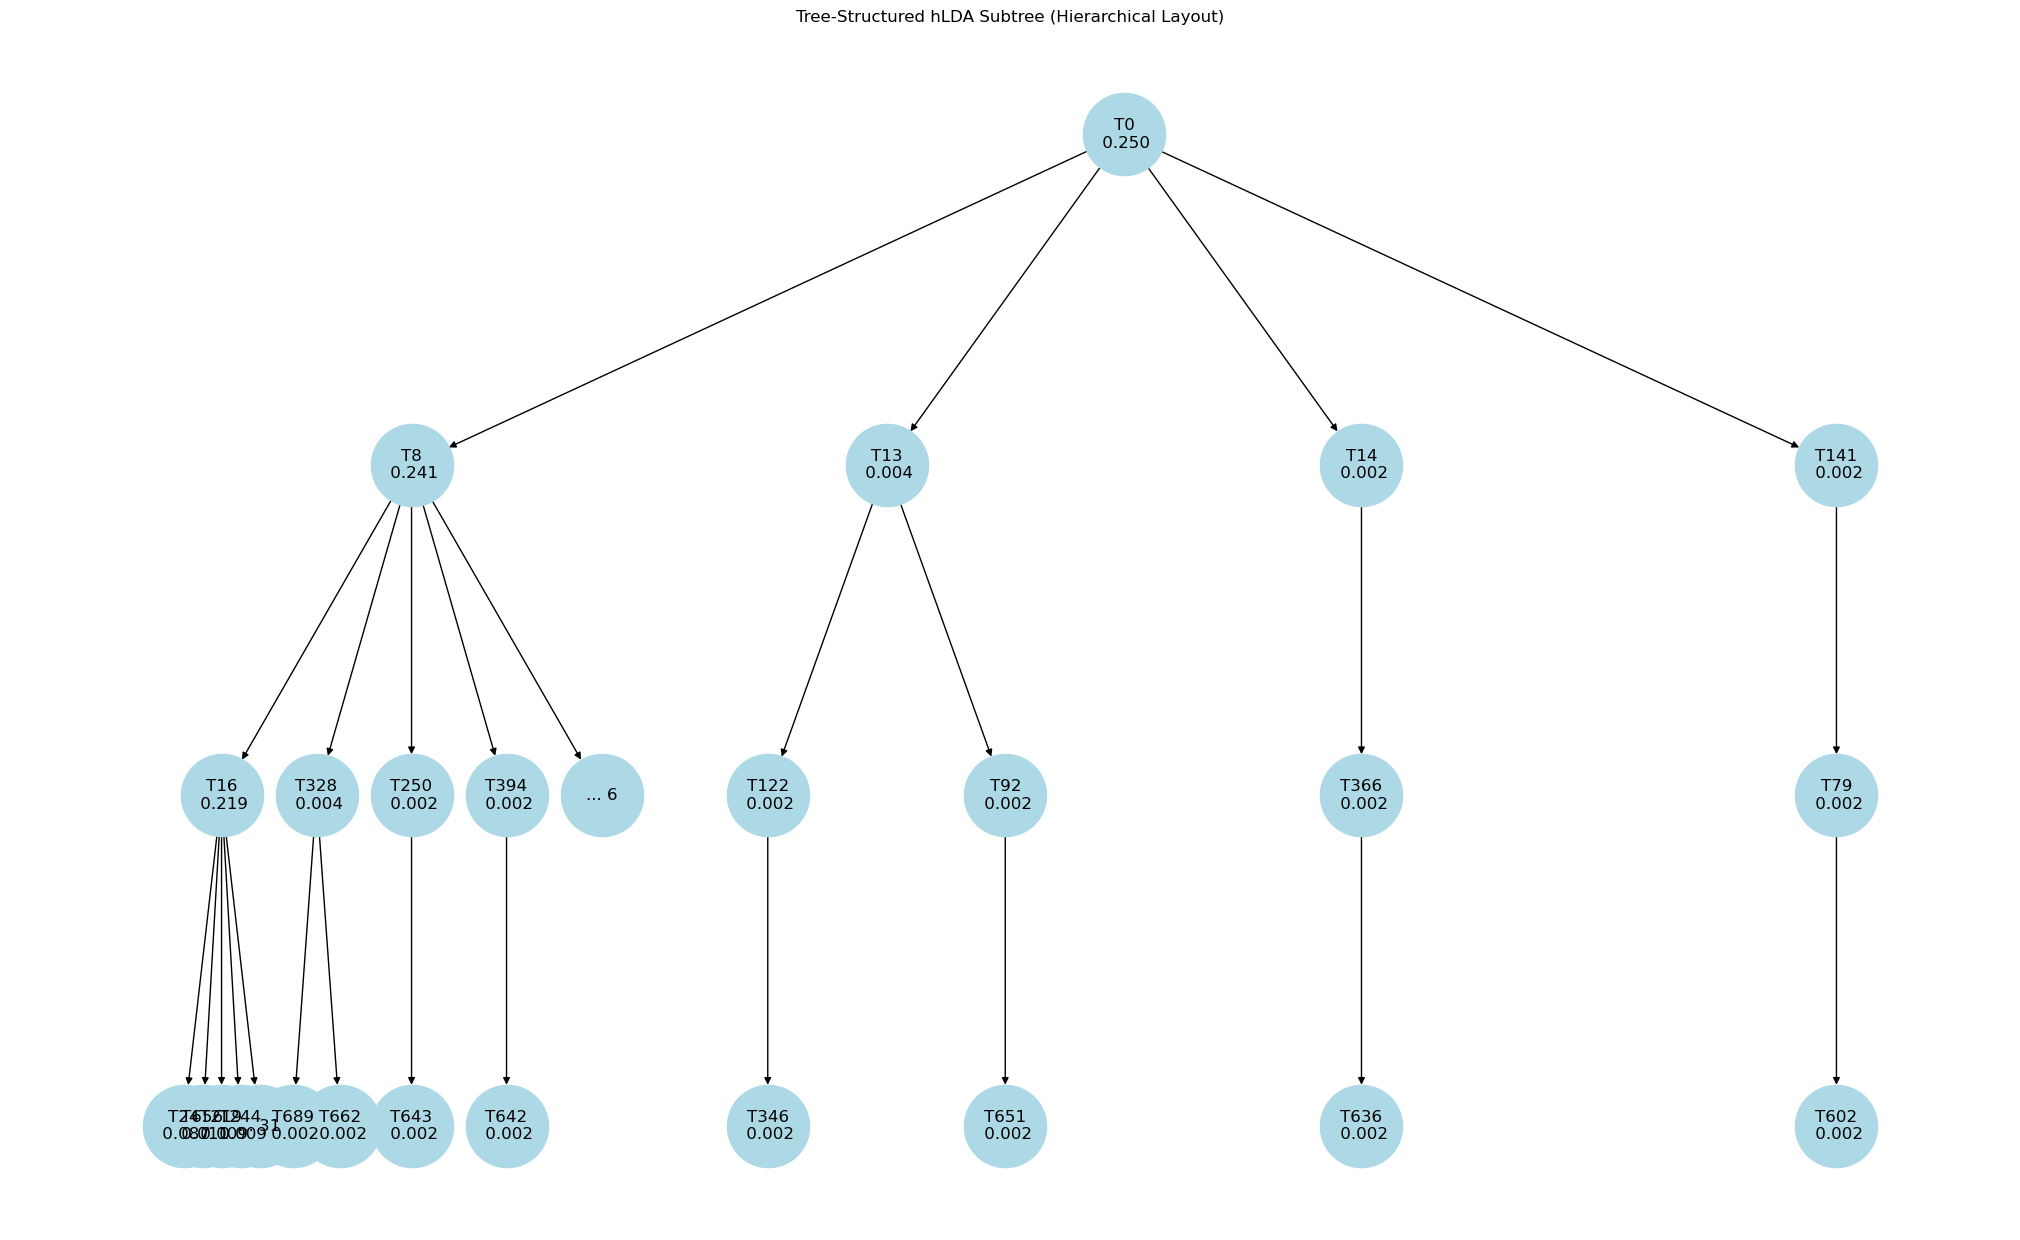

In [61]:
# -------------------------------
# Visulisation Functions
# -------------------------------
def hierarchy_pos(
    G,
    root=None,
    width=1.0,
    vert_gap=0.2,
    vert_loc=0,
    xcenter=0.5,
    pos=None,
    parent=None
):
    if pos is None:
        pos = {root: (xcenter, vert_loc)}
    else:
        pos[root] = (xcenter, vert_loc)
    children = list(G.successors(root))
    if len(children) != 0:
        dx = width / len(children)
        nextx = xcenter - width / 2 - dx / 2
        for child in children:
            nextx += dx
            pos = hierarchy_pos(
                G,
                root=child,
                width=dx,
                vert_gap=vert_gap,
                vert_loc=vert_loc - vert_gap,
                xcenter=nextx,
                pos=pos,
                parent=root
            )
    return pos
# Suppose `subtree_comm` is your pruned subtree for the chosen community.
# Example: subtree_comm = reconstruct_subtree_pruned(model_hlda, norm_dist_comm, ...)

# We limit each node to the top K children by probability
TOP_K_CHILDREN = 4

G = nx.DiGraph()
node_id_counter = [0]  # store the next node ID in a list so we can mutate it

def add_subtree_to_graph(node, parent_id=None, top_k=TOP_K_CHILDREN):
    """
    Recursively add `node` to the DiGraph, including up to `top_k` children.
    If there are more children, group them into a single placeholder node.
    """
    current_id = node_id_counter[0]
    node_id_counter[0] += 1
    
    # Create a label showing the node’s level, topic ID, and probability
    label = f"T{node['topic_id']}\n {node['probability']:.3f}"
    G.add_node(current_id, label=label)
    
    # Link from parent to current node
    if parent_id is not None:
        G.add_edge(parent_id, current_id)
    
    # Sort children by descending probability
    children = sorted(node["children"], key=lambda c: c["probability"], reverse=True)
    
    # If we have more children than top_k, group the rest
    if len(children) > top_k:
        # Add the top_k children
        for child in children[:top_k]:
            add_subtree_to_graph(child, parent_id=current_id, top_k=top_k)
        
        # Add a placeholder node summarizing how many were omitted
        leftover_count = len(children) - top_k
        placeholder_id = node_id_counter[0]
        node_id_counter[0] += 1
        G.add_node(placeholder_id, label=f"... {leftover_count}")
        G.add_edge(current_id, placeholder_id)
    else:
        # Otherwise, add them all
        for child in children:
            add_subtree_to_graph(child, parent_id=current_id, top_k=top_k)

# -- Build the graph from your subtree --
if subtree_comm is None:
    print("No subtree found for the chosen community.")
else:
    add_subtree_to_graph(subtree_comm, parent_id=None)

    # We'll assume that the node with ID=0 is the root node in this new graph.
    root_id = 0  # The very first node we added

    # Compute a hierarchical layout
    pos = hierarchy_pos(G, root=root_id, width=4.0, vert_gap=0.8)
    
    # Retrieve node labels
    node_labels = nx.get_node_attributes(G, 'label')
    
    # Plot
    plt.figure(figsize=(20, 12))
    nx.draw(
        G, pos,
        labels=node_labels,
        with_labels=True,
        node_color='lightblue',
        node_size=3500,
        font_size=12,
        arrows=True
    )
    plt.title("Tree-Structured hLDA Subtree (Hierarchical Layout)")
    plt.show()

In [62]:
def extract_top_words_with_level(node, model, result=None):
    """
    Recursively traverse the subtree and for each node, extract:
      - level (stored in node["level"])
      - topic_id (stored in node["topic_id"])
      - node probability (stored in node["probability"])
      - top 20 words (retrieved from model.get_topic_words(topic_id, top_n=20))
      
    Returns a list of dictionaries.
    """
    if result is None:
        result = []
    
    # Retrieve top 20 words for this node from the model
    top_words = model.get_topic_words(node["topic_id"], top_n=20)
    result.append({
        "level": node["level"],
        "topic_id": node["topic_id"],
        "node_probability": node["probability"],
        "top_words": top_words
    })
    
    for child in node.get("children", []):
        extract_top_words_with_level(child, model, result)
        
    return result

# Example usage:
if subtree_comm is None:
    print("No subtree available for extraction.")
else:
    top_words_info = extract_top_words_with_level(subtree_comm, model_hlda)
    
    print("Top 20 words for each node in the subtree:")
    for info in top_words_info:
        print(f"Level {info['level']} - Topic {info['topic_id']} (Node Prob: {info['node_probability']:.3f}):")
        # Print each word with its probability (rounded)
        for word, prob in info["top_words"]:
            print(f"    {word}: {prob:.4f}")
        print()

Top 20 words for each node in the subtree:
Level 0 - Topic 0 (Node Prob: 0.250):
    model: 0.0325
    method: 0.0248
    data: 0.0241
    approach: 0.0133
    study: 0.0129
    using: 0.0125
    analysis: 0.0109
    used: 0.0093
    based: 0.0083
    two: 0.0074
    estimate: 0.0073
    proposed: 0.0072
    propose: 0.0069
    variable: 0.0068
    use: 0.0066
    also: 0.0065
    simulation: 0.0065
    article: 0.0062
    inference: 0.0062
    new: 0.0061

Level 1 - Topic 14 (Node Prob: 0.002):
    seasonal: 0.0516
    year: 0.0516
    spatial: 0.0413
    departure: 0.0413
    air: 0.0310
    residual: 0.0310
    prediction: 0.0310
    delay: 0.0310
    nonparametric: 0.0207
    improve: 0.0207
    united: 0.0207
    akaike: 0.0207
    early: 0.0104
    increased: 0.0104
    specie: 0.0104
    california: 0.0104
    demonstrates: 0.0104
    rare: 0.0104
    wildfire: 0.0104
    sensitive: 0.0104

Level 2 - Topic 366 (Node Prob: 0.002):
    wildfire: 0.0572
    index: 0.0572
    contri

```
Topic 0: General modelling  
├── Topic 14: Seasonal pattern  
│   └── Topic 366: Wildfire  
│       └── Topic 636: Survival and impact analysis  
├── Topic 13: Bayesian inference with Markov chains  
│   ├── Topic 122: Verifying estimation procedures  
│   │   └── Topic 346: Robust geometric inclusion modeling  
│   └── Topic 92: Ecological modeling – Beetle and forest dynamics  
│       └── Topic 651: Exponential forest decline modeling  
├── Topic 141: Health and mortality studies  
│   └── Topic 79: Life expectancy and disability estimation  
│       └── Topic 602: Event history and survival data  
├── Topic 8: Theoretical statistics and estimation  
│   ├── Topic 250: Biological cycles and circular regression  
│   │   └── Topic 643: MCMC and Langevin sampling algorithms  
│   ├── Topic 394: Policy and state-dependent systems  
│   │   └── Topic 642: Environmental monitoring and ozone trend  
│   ├── Topic 328: Survey response styles and attitudes  
│   │   └── Topic 689: Animal survival and ecological capture  
│   ├── Topic 396: Statistical independence and transformation  
│   │   └── Topic 376: Particle filtering and dynamic state estimation  
│   ├── Topic 151: Brain tissue classification with Markov fields  
│   │   └── Topic 686: Bayesian spatial regression for imaging  
│   ├── Topic 126: Survey estimation in small domains  
│   │   └── Topic 80: Spatial autoregressions and variogram analysis  
│   └── Topic 211: Saddlepoint approximation and density modeling  
    └── Topic 515: Joint distributions and recursive likelihood computation  
```

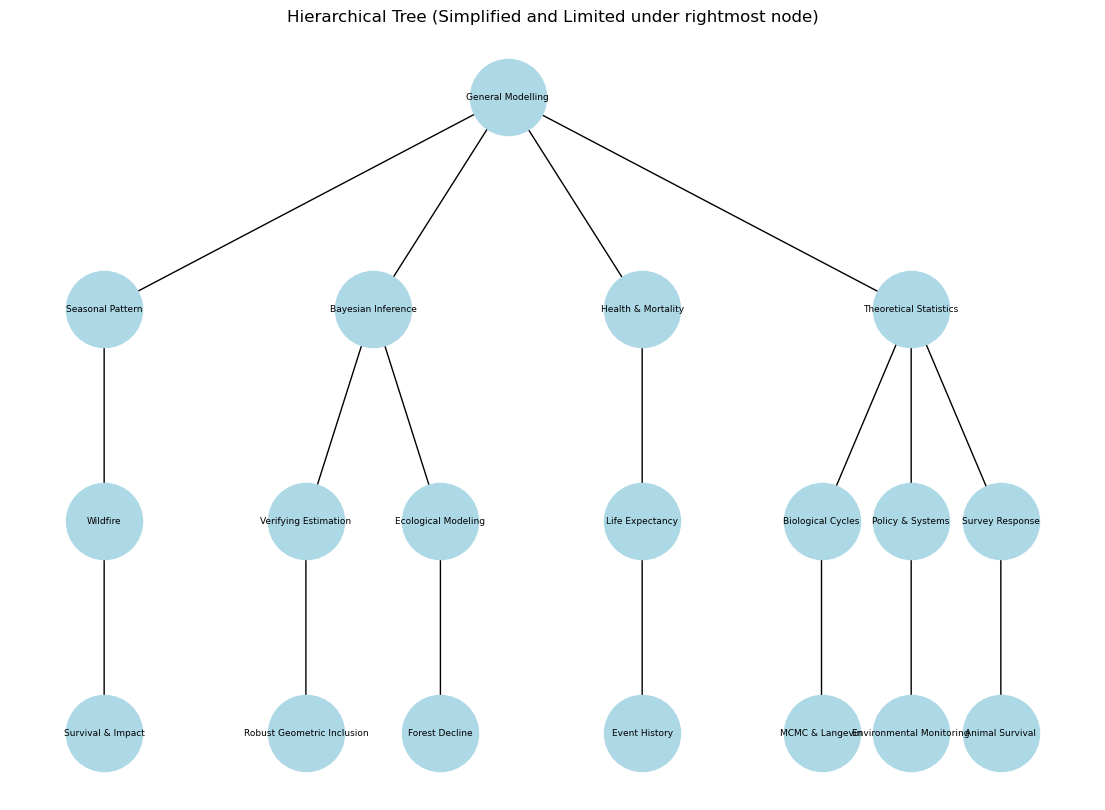

In [74]:
import networkx as nx
import matplotlib.pyplot as plt

# -------------------------------
# 1. Define the Simplified Topic Tree
# -------------------------------
# Note: The names here no longer include the "T___" labels.
tree = {
    "topic_id": 0,
    "name": "General Modelling",
    "children": [
        {
            "topic_id": 14,
            "name": "Seasonal Pattern",
            "children": [
                {
                    "topic_id": 366,
                    "name": "Wildfire",
                    "children": [
                        {
                            "topic_id": 636,
                            "name": "Survival & Impact",
                            "children": []
                        }
                    ]
                }
            ]
        },
        {
            "topic_id": 13,
            "name": "Bayesian Inference",
            "children": [
                {
                    "topic_id": 122,
                    "name": "Verifying Estimation",
                    "children": [
                        {
                            "topic_id": 346,
                            "name": "Robust Geometric Inclusion",
                            "children": []
                        }
                    ]
                },
                {
                    "topic_id": 92,
                    "name": "Ecological Modeling",
                    "children": [
                        {
                            "topic_id": 651,
                            "name": "Forest Decline",
                            "children": []
                        }
                    ]
                }
            ]
        },
        {
            "topic_id": 141,
            "name": "Health & Mortality",
            "children": [
                {
                    "topic_id": 79,
                    "name": "Life Expectancy",
                    "children": [
                        {
                            "topic_id": 602,
                            "name": "Event History",
                            "children": []
                        }
                    ]
                }
            ]
        },
        {
            "topic_id": 8,
            "name": "Theoretical Statistics",
            "children": [
                # Only include 3 children for T8:
                {
                    "topic_id": 250,
                    "name": "Biological Cycles",
                    "children": [
                        {
                            "topic_id": 643,
                            "name": "MCMC & Langevin",
                            "children": []
                        }
                    ]
                },
                {
                    "topic_id": 394,
                    "name": "Policy & Systems",
                    "children": [
                        {
                            "topic_id": 642,
                            "name": "Environmental Monitoring",
                            "children": []
                        }
                    ]
                },
                {
                    "topic_id": 328,
                    "name": "Survey Response",
                    "children": [
                        {
                            "topic_id": 689,
                            "name": "Animal Survival",
                            "children": []
                        }
                    ]
                }
            ]
        }
    ]
}

# -------------------------------
# 2. Build a NetworkX DiGraph from the Tree
# -------------------------------
G = nx.DiGraph()
node_id_counter = [0]  # mutable counter for unique node IDs

def add_tree_to_graph(node, parent_id=None):
    current_id = node_id_counter[0]
    node_id_counter[0] += 1
    
    # Use the simplified node name only.
    label = node["name"]
    G.add_node(current_id, label=label)
    
    if parent_id is not None:
        G.add_edge(parent_id, current_id)
    
    for child in node.get("children", []):
        add_tree_to_graph(child, parent_id=current_id)

add_tree_to_graph(tree)
root_id = 0  # assuming the first node added is the root

# -------------------------------
# 3. Custom Hierarchical Positioning (Top-Down)
# -------------------------------
def hierarchy_pos(G, root=None, width=1.0, vert_gap=0.2, vert_loc=0, xcenter=0.5, pos=None, parent=None):
    """
    Compute the positions for a top-down hierarchical layout.
    """
    if pos is None:
        pos = {root: (xcenter, vert_loc)}
    else:
        pos[root] = (xcenter, vert_loc)
        
    children = list(G.successors(root))
    if children:
        dx = width / len(children)
        nextx = xcenter - width / 2 - dx / 2
        for child in children:
            nextx += dx
            pos = hierarchy_pos(G, root=child, width=dx, vert_gap=vert_gap,
                                vert_loc=vert_loc - vert_gap, xcenter=nextx,
                                pos=pos, parent=root)
    return pos

# Compute positions with adjusted spacing for clarity.
pos = hierarchy_pos(G, root=root_id, width=2.0, vert_gap=0.8)

# -------------------------------
# 4. Plot the Hierarchical Tree
# -------------------------------
plt.figure(figsize=(14, 10))
node_labels = nx.get_node_attributes(G, 'label')

nx.draw_networkx_edges(
    G, pos,
    arrows=True,
    arrowstyle='-|>',
    arrowsize=12
)
nx.draw_networkx_nodes(
    G, pos,
    node_color='lightblue',
    node_size=3000
)
nx.draw_networkx_labels(
    G, pos,
    labels=node_labels,
    font_size=6.5
)

plt.title("Hierarchical Tree (Simplified and Limited under rightmost node)")
plt.axis("off")
plt.show()

# Topic-topic relationship 1

## Extracting information from the deepest topic

In [137]:
# Step 1: Extract deepest layer topics from hLDA
max_depth = 4
deepest_topics = []
for topic_id in range(model_hlda.k):
    if model_hlda.level(topic_id) == max_depth - 1:
        deepest_topics.append(topic_id)

In [176]:
print("Deepest topics (final layer):", deepest_topics)

Deepest topics (final layer): [24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 48, 49, 50, 51, 52, 53, 54, 55, 64, 65, 66, 67, 68, 69, 70, 71, 80, 81, 82, 83, 84, 85, 86, 87, 96, 97, 98, 99, 100, 101, 102, 103, 112, 113, 114, 115, 116, 117, 118, 119, 128, 129, 130, 131, 132, 133, 134, 135, 152, 153, 154, 155, 156, 157, 158, 159, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 256, 257, 258, 259, 260, 261, 262, 263, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346

In [139]:
# Step 2: Create topic vectors using top words

# Collect all top words and their probabilities
topic_word_dicts = []
for topic_id in deepest_topics:
    words_probs = model_hlda.get_topic_words(topic_id, top_n=20)
    topic_word_dicts.append({word: prob for word, prob in words_probs})
    
# Create a unified vocabulary
all_words = list(set().union(*[d.keys() for d in topic_word_dicts]))
topic_vectors = pd.DataFrame(0.0, columns=all_words, index=deepest_topics)

for idx, topic_id in enumerate(deepest_topics):
    for word, prob in topic_word_dicts[idx].items():
        topic_vectors.loc[topic_id, word] = prob

In [113]:
zero_rows = topic_vectors.index[(topic_vectors == 0).all(axis=1)]
if len(zero_rows) > 0:
    print("Warning: Topics with all-zero vectors:", list(zero_rows))
else:
    print("All topic vectors have non-zero entries.")

All topic vectors have non-zero entries.


In [140]:
# Step 3: Build topic-topic network
threshold = 0.2
similarity_matrix = cosine_similarity(topic_vectors)

G_topic = nx.Graph()
for i in range(len(deepest_topics)):
    for j in range(i+1, len(deepest_topics)):
        if similarity_matrix[i,j] > threshold:
            G_topic.add_edge(deepest_topics[i], deepest_topics[j])

In [141]:
print("Topic-Topic Network:")
print("  Number of nodes:", G_topic.number_of_nodes())
print("  Number of edges:", G_topic.number_of_edges())

Topic-Topic Network:
  Number of nodes: 472
  Number of edges: 2137


In [142]:
# Step 4: Run SBM on topic network
G_topic_gt = gt.Graph(directed=False)
node_map = {t: G_topic_gt.add_vertex() for t in deepest_topics}

for u, v in G_topic.edges():
    G_topic_gt.add_edge(node_map[u], node_map[v])

# Run SBM with limited communities
state_topic = gt.minimize_blockmodel_dl(G_topic_gt, state_args={"B": 5})
blocks_topic = state_topic.get_blocks()

# Create community mapping
topic_communities = {t: blocks_topic[node_map[t]] for t in deepest_topics}

In [143]:
# Check the number of topic communities and their sizes
unique_topic_comms = set(topic_communities.values())
print("Number of topic communities:", len(unique_topic_comms))

community_sizes = {comm: sum(1 for t in topic_communities if topic_communities[t] == comm) for comm in unique_topic_comms}
print("Topic community sizes:")
for comm, size in community_sizes.items():
    print(f"  Community {comm}: {size} topics")

Number of topic communities: 21
Topic community sizes:
  Community 128: 4 topics
  Community 8: 28 topics
  Community 154: 146 topics
  Community 416: 44 topics
  Community 294: 15 topics
  Community 40: 14 topics
  Community 169: 14 topics
  Community 435: 21 topics
  Community 186: 28 topics
  Community 60: 24 topics
  Community 62: 15 topics
  Community 193: 7 topics
  Community 322: 8 topics
  Community 68: 13 topics
  Community 199: 15 topics
  Community 206: 24 topics
  Community 92: 11 topics
  Community 362: 19 topics
  Community 238: 19 topics
  Community 367: 53 topics
  Community 494: 5 topics


In [144]:
# Step 5: Aggregate top words per community
community_words = defaultdict(Counter)
for topic_id in deepest_topics:
    comm = topic_communities[topic_id]
    words = [word for word, _ in model_hlda.get_topic_words(topic_id, top_n=20)]
    community_words[comm].update(words)

# Get top 20 words per community
community_top_words = {comm: [w for w, _ in cnt.most_common(20)] 
                      for comm, cnt in community_words.items()}

# Print results
print("\nTopic community Top Words:")
for comm, words in community_top_words.items():
    print(f"Community {comm}: {', '.join(words[:10])}...")



Topic community Top Words:
Community 128: model, process, bayesian, prior, posterior, sampling, mixture, dirichlet, point, markov...
Community 238: risk, procedure, rate, group, testing, process, disease, individual, bayes, inequality...
Community 154: process, likelihood, proposed, based, problem, using, estimation, procedure, test, probability...
Community 416: component, functional, curve, data, principal, process, analysis, smoothing, multiscale, missing...
Community 367: regression, variable, selection, response, predictor, image, covariates, measure, gene, method...
Community 186: matrix, n, covariance, x, sparse, likelihood, process, graph, spatial, vector...
Community 8: algorithm, likelihood, parameter, carlo, problem, using, process, nuisance, stratum, number...
Community 68: model, test, selection, criterion, forecast, spline, covariance, function, time, multivariate...
Community 435: design, outcome, orthogonal, exposure, class, experiment, p, effect, array, result...
Comm

In [145]:
# Step 6: Map documents to topic communities
doc_topic_mapping = {}
for i, doc in enumerate(model_hlda.docs):
    path = doc.path
    deepest_topic = path[-1]
    paper_id = doc_mapping[i]
    doc_topic_mapping[paper_id] = topic_communities.get(deepest_topic, -1) # -1 means that the topic is not in the topic-topic network.

In [153]:
# Step 7: Compute document community topic distributions
# First map papers to their original communities (from SBM)
paper_initial_communities = {paper_id_prop[v]: filtered_labels[i] 
                            for i, v in enumerate(G_filtered.vertices())}

# Create distribution matrix
all_topic_comms = sorted(set(topic_communities.values()))
comm_distributions = defaultdict(lambda: np.zeros(len(all_topic_comms)))

for paper_id, doc_comm in paper_initial_communities.items():
    topic_comm = doc_topic_mapping.get(paper_id, None)
    if topic_comm is not None and topic_comm in all_topic_comms:
        idx = all_topic_comms.index(topic_comm)
        comm_distributions[doc_comm][idx] += 1

# Normalize distributions
for comm in comm_distributions:
    total = comm_distributions[comm].sum()
    if total > 0:
        comm_distributions[comm] = comm_distributions[comm] / total

# Print results
print("\nTopic community Top Words:")
for comm, words in community_top_words.items():
    print(f"Community {comm}: {', '.join(words[:10])}...")


Topic community Top Words:
Community 348: model, bayesian, prior, process, markov, chain, monte, carlo, algorithm, posterior...
Community 292: process, likelihood, proposed, based, using, problem, procedure, regression, estimation, test...
Community 209: functional, principal, curve, component, analysis, penalty, dynamic, noise, surface, predictor...
Community 318: algorithm, number, iteration, carlo, weighted, practical, em, simulation, particle, filter...
Community 170: model, space, field, time, markov, change, mean, graph, climate, temperature...
Community 448: data, missing, exposure, variable, mechanism, inference, assumption, outcome, covariate, identified...
Community 363: estimator, wavelet, error, mean, thresholding, prediction, model, predictor, mspe, square...
Community 330: smoothing, regression, component, selection, additive, spline, penalty, criterion, generalized, bias...
Community 99: process, robust, time, point, intensity, volatility, diffusion, spatial, income, li

In [154]:
print("\nDocument Community Topic Distributions:")
for doc_comm, dist in comm_distributions.items():
    print(f"Document Community {doc_comm}:")
    for tc_idx, prob in enumerate(dist):
        print(f"  Topic Community {all_topic_comms[tc_idx]}: {prob:.2f}")


Document Community Topic Distributions:
Document Community 564:
  Topic Community 6: 0.02
  Topic Community 13: 0.02
  Topic Community 18: 0.00
  Topic Community 57: 0.04
  Topic Community 99: 0.02
  Topic Community 128: 0.02
  Topic Community 170: 0.06
  Topic Community 194: 0.00
  Topic Community 209: 0.00
  Topic Community 216: 0.00
  Topic Community 221: 0.10
  Topic Community 282: 0.02
  Topic Community 292: 0.31
  Topic Community 300: 0.02
  Topic Community 303: 0.06
  Topic Community 313: 0.00
  Topic Community 318: 0.00
  Topic Community 330: 0.00
  Topic Community 348: 0.08
  Topic Community 359: 0.12
  Topic Community 363: 0.02
  Topic Community 432: 0.00
  Topic Community 439: 0.02
  Topic Community 448: 0.02
  Topic Community 460: 0.06
  Topic Community 501: 0.02
  Topic Community 511: 0.00
Document Community 189:
  Topic Community 6: 0.00
  Topic Community 13: 0.00
  Topic Community 18: 0.00
  Topic Community 57: 0.00
  Topic Community 99: 0.56
  Topic Community 128: 0.00

## Visulisations

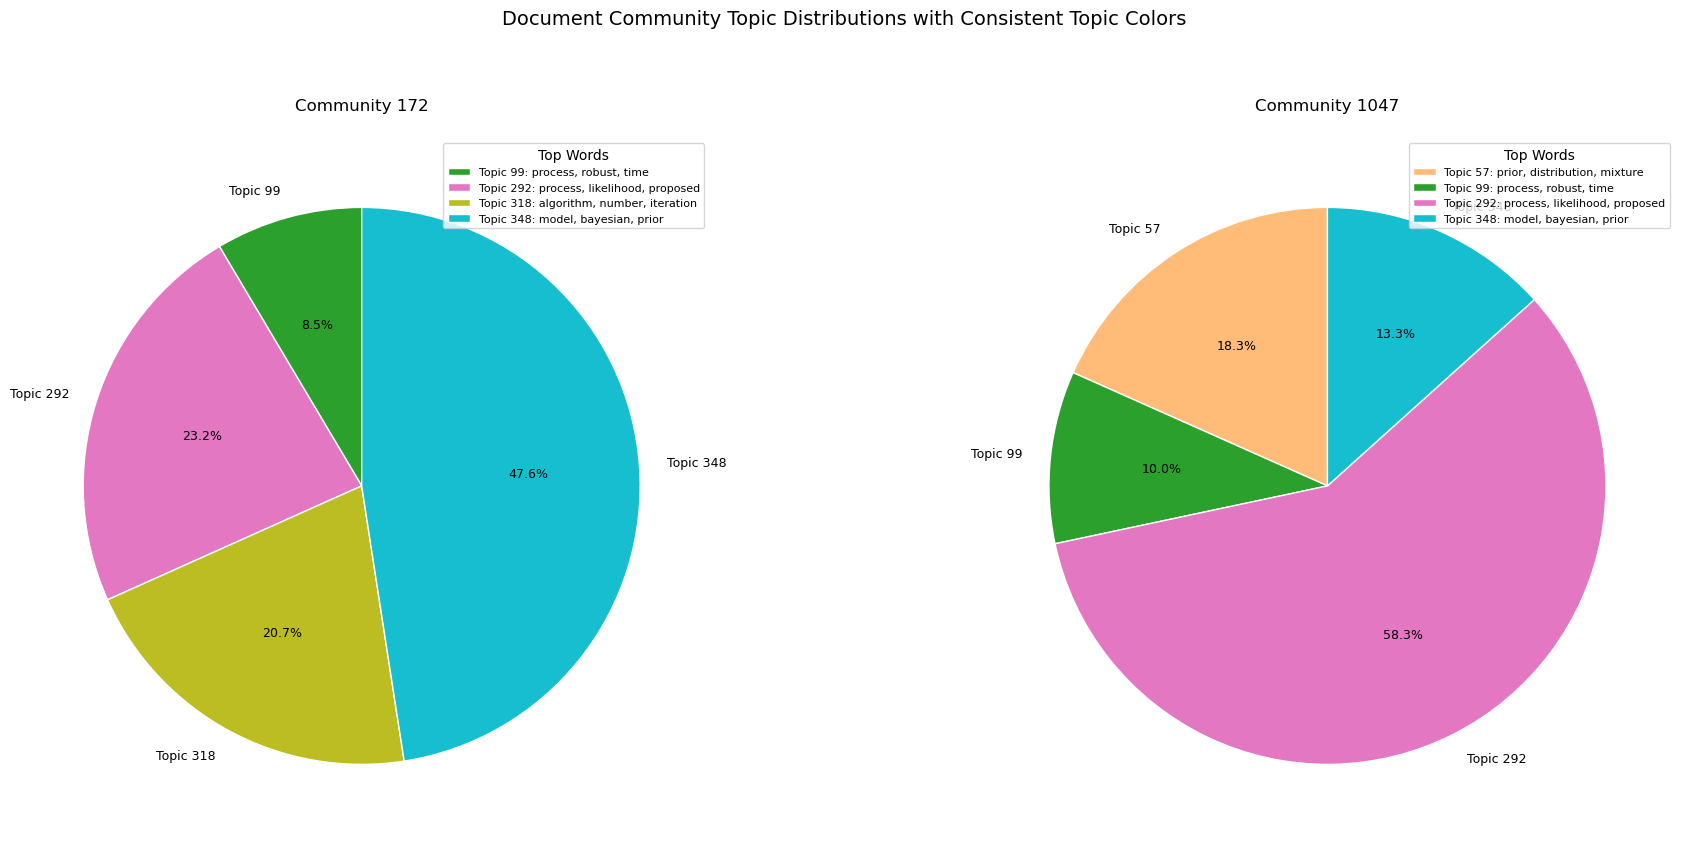

In [162]:
## Visualizations

# Get community sizes from filtered_labels
community_sizes = Counter(filtered_labels)

# Select communities to visualize
communities_to_plot = [172, 1047] 

# Create a consistent color mapping for all topic communities
all_possible_topics = sorted(set(topic_communities.values()))
topic_colors = {tc: plt.cm.tab20(i % 20) for i, tc in enumerate(all_possible_topics)}

# Create figure with subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 8))
if len(communities_to_plot) == 1:  # Handle case when only one community
    axes = [axes]

# Plot each community's distribution
for ax, comm in zip(axes, communities_to_plot):
    if comm not in comm_distributions:
        ax.text(0.5, 0.5, f"No data\nfor {comm}", ha='center', va='center', fontsize=12)
        ax.axis('off')
        continue
    
    dist = comm_distributions[comm]
    
    # Filter out small contributions (<5%) for cleaner visualization
    threshold = 0.05
    mask = dist >= threshold
    filtered_dist = dist[mask]
    filtered_topic_comms = [all_topic_comms[i] for i, keep in enumerate(mask) if keep]
    
    if len(filtered_dist) == 0:
        ax.text(0.5, 0.5, "All topics <5%", ha='center', va='center')
       
        ax.axis('off')
        continue
    
    # Get top words for each topic community being shown
    top_words = {}
    for tc in filtered_topic_comms:
        top_words[tc] = community_top_words.get(tc, ["N/A"])[:3]  # Get top 3 words
    
    # Get colors for these topics from our consistent mapping
    colors = [topic_colors[tc] for tc in filtered_topic_comms]
    
    # Create pie chart
    wedges, texts, autotexts = ax.pie(
        filtered_dist,
        labels=[f"Topic {tc}" for tc in filtered_topic_comms],
        autopct=lambda p: f'{p:.1f}%' if p >= 5 else '',  # Only show % for >=5%
        startangle=90,
        colors=colors,
        wedgeprops={'linewidth': 1, 'edgecolor': 'white'},
        textprops={'fontsize': 9}
    )
    
    # Add legend at top right
    legend_labels = [f"Topic {tc}: {', '.join(top_words[tc])}" for tc in filtered_topic_comms]
    ax.legend(wedges, legend_labels,
              title="Top Words",
              loc='upper right',
              bbox_to_anchor=(1, 1),
              fontsize=8)
    
    ax.set_title(f"Community {comm}", pad=20)

# Remove empty subplots if any
for ax in axes[len(communities_to_plot):]:
    ax.axis('off')

plt.suptitle("Document Community Topic Distributions with Consistent Topic Colors", y=1.05, fontsize=14)
plt.tight_layout()
plt.show()

# Topic-topic relationship

Incorporating network information into inferred hLDA tree.

In [77]:
from sklearn.metrics.pairwise import cosine_similarity

# ==============================================================
# Step 1: Compute Topic Distribution Vectors Based on the hLDA Tree
# ==============================================================

# For each document (indexed by i in model_hlda.docs), record its community
# and for each level in its topic path, count the occurrence for that (level, topic_id)
topic_counts = defaultdict(lambda: defaultdict(float))  # key: (level, topic_id) -> {community: count}

for i, paper_id in enumerate(doc_mapping):
    comm = paper_community.get(paper_id, None)
    if comm is not None:
        doc = model_hlda.docs[i]
        for lvl, topic in enumerate(doc.path):
            key = (lvl, int(topic))
            topic_counts[key][comm] += 1

# Get the set of all communities that appear
all_communities = sorted({comm for counts in topic_counts.values() for comm in counts.keys()})

# For each topic (defined by (level, topic_id)), build its normalized community distribution vector.
# Also store the list of communities where the topic appears.
topic_vectors = {}  # key: (level, topic_id) -> { "vector": np.array, "communities": [comm, ...] }
for key, comm_counts in topic_counts.items():
    total = sum(comm_counts.values())
    vector = np.array([comm_counts.get(c, 0) / total for c in all_communities])
    communities_list = [c for c in all_communities if comm_counts.get(c, 0) > 0]
    topic_vectors[key] = {"vector": vector, "communities": communities_list}

# ==============================================================
# Step 2: Compute Cosine Similarity Between Topics
# ==============================================================

# Set a similarity threshold
similarity_threshold = 0.25
topic_edges = []  # list to store edges: (topic_key1, topic_key2, similarity)

# Create a list of unique topics (keys are (level, topic_id))
topic_keys = list(topic_vectors.keys())
n_topics = len(topic_keys)

# Compute cosine similarity for each pair of topics
for i in range(n_topics):
    for j in range(i+1, n_topics):
        vec_i = topic_vectors[topic_keys[i]]["vector"]
        vec_j = topic_vectors[topic_keys[j]]["vector"]
        norm_i = np.linalg.norm(vec_i)
        norm_j = np.linalg.norm(vec_j)
        if norm_i == 0 or norm_j == 0:
            sim = 0.0
        else:
            sim = np.dot(vec_i, vec_j) / (norm_i * norm_j + 1e-10)
        if sim > similarity_threshold:
            topic_edges.append((topic_keys[i], topic_keys[j], sim))

# ==============================================================
# Step 3: Build the Topic-Topic Network
# ==============================================================

# Create an undirected graph where each node represents a unique topic (level, topic_id)
T = nx.Graph()

# Add nodes with attributes: topic_id, level, and the communities in which the topic appears.
for key, data in topic_vectors.items():
    level, topic_id = key
    T.add_node(key, topic_id=topic_id, level=level, communities=data["communities"])

# Add edges with weight equal to the cosine similarity between topics.
for u, v, weight in topic_edges:
    T.add_edge(u, v)

print("Topic-Topic Network Constructed:")
print("Number of nodes:", T.number_of_nodes())
print("Number of edges:", T.number_of_edges())

# Now, T is your topic-topic network where each node has attributes:
# - topic_id: the topic identifier from the hLDA tree
# - level: the level in the hierarchy
# - communities: a list of communities where this topic appears (based on document traversal)
#
# Edges are added between topics whose community distribution vectors are similar
# (cosine similarity > similarity_threshold), with the edge weight reflecting that similarity.

Topic-Topic Network Constructed:
Number of nodes: 669
Number of edges: 22999


In [84]:
# Number of connected components
num_components = nx.number_connected_components(T)
print("Number of connected components:", num_components)

# Get the connected components and their sizes
components = sorted(nx.connected_components(T), key=len, reverse=True)
component_sizes = [len(comp) for comp in components]
print("Component sizes:", component_sizes)

# Graph density (sparsity is the inverse or low value indicates high sparsity)
density = nx.density(T)
print("Graph density:", density)

# Average clustering coefficient
avg_clustering = nx.average_clustering(T)
print("Average clustering coefficient:", avg_clustering)

# Analyzing the largest connected component
largest_cc = max(nx.connected_components(T), key=len)
T_largest = T.subgraph(largest_cc)
if nx.is_connected(T_largest):
    diameter = nx.diameter(T_largest)
    avg_shortest_path = nx.average_shortest_path_length(T_largest)
    print("Diameter of largest component:", diameter)
    print("Average shortest path length in largest component:", avg_shortest_path)
    


Number of connected components: 1
Component sizes: [669]
Graph density: 0.10292867180437332
Average clustering coefficient: 0.5721226751755096
Diameter of largest component: 3
Average shortest path length in largest component: 1.9751438826383108


# Analysis of topic-topic netwrok

In [78]:
# Compute betweenness centrality for all nodes (topics) in the topic-topic network
# Use edge weights (similarity) if available, as they reflect connection strength
betweenness = nx.betweenness_centrality(T, weight='weight')  # Assuming edges have 'weight' attribute

# Sort topics by centrality and filter top bridging topics
TOP_N = 10  # Adjust as needed
sorted_bridging_topics = sorted(
    betweenness.items(), 
    key=lambda x: x[1], 
    reverse=True
)[:TOP_N]

# Print results
print("Top Bridging Topics:")
for (topic_key, centrality) in sorted_bridging_topics:
    level, topic_id = topic_key
    communities = T.nodes[topic_key]["communities"]
    print(
        f"Topic (Level {level}, ID {topic_id}): "
        f"Centrality = {centrality:.3f}, "
        f"Communities = {communities}"
    )

Top Bridging Topics:
Topic (Level 0, ID 0): Centrality = 0.021, Communities = [172, 189, 196, 253, 282, 307, 342, 393, 457, 476, 524, 564, 644, 736, 738, 883, 918, 925, 960, 987, 1047, 1106, 1172, 1329, 1331, 1365, 1376, 1442, 1603, 1607, 1675, 1717, 1719, 1769, 1878, 2150, 2159, 2376, 2417, 2476, 2593, 2846, 2925]
Topic (Level 1, ID 8): Centrality = 0.020, Communities = [172, 189, 196, 253, 282, 307, 342, 393, 457, 476, 524, 564, 644, 736, 738, 883, 918, 925, 960, 987, 1047, 1106, 1172, 1329, 1331, 1365, 1376, 1442, 1603, 1607, 1675, 1717, 1719, 1769, 1878, 2150, 2159, 2376, 2417, 2476, 2593, 2846, 2925]
Topic (Level 2, ID 271): Centrality = 0.019, Communities = [393, 476, 524, 925, 1106, 1365, 1603, 1607, 1675, 1878, 2159]
Topic (Level 1, ID 137): Centrality = 0.019, Communities = [524, 883, 960, 987, 1047, 1172, 1376, 1603, 1878, 2376, 2846]
Topic (Level 2, ID 16): Centrality = 0.014, Communities = [172, 189, 196, 253, 282, 307, 342, 393, 457, 476, 524, 564, 644, 736, 738, 883, 918,

## 1. Bridging Topics Between Communities

### 1.1. Overview

In our topic-topic network, we computed the betweenness centrality for each topic to identify those that serve as "bridges" between different communities. These bridging topics are key connectors in the network, indicating that they appear on many of the shortest paths between other topics and hence link diverse research areas.

### 1.2. Betweenness Centrality Calculation

The betweenness centrality for a node is calculated 

### 1.3. Top Bridging Topics (Extracted Results)

Below are the top bridging topics identified along with their betweenness centrality values and the list of communities in which each topic appears:

- **Topic (Level 0, ID 0):General modeling**  
  *Centrality = 0.021*  
  *Communities = [172, 189, 196, 253, 282, 307, 342, 393, 457, 476, 524, 564, 644, 736, 738, 883, 918, 925, 960, 987, 1047, 1106, 1172, 1329, 1331, 1365, 1376, 1442, 1603, 1607, 1675, 1717, 1719, 1769, 1878, 2150, 2159, 2376, 2417, 2476, 2593, 2846, 2925]*

- **Topic (Level 1, ID 8): Statistical estimation**  
  *Centrality = 0.020*  
  *Communities = [172, 189, 196, 253, 282, 307, 342, 393, 457, 476, 524, 564, 644, 736, 738, 883, 918, 925, 960, 987, 1047, 1106, 1172, 1329, 1331, 1365, 1376, 1442, 1603, 1607, 1675, 1717, 1719, 1769, 1878, 2150, 2159, 2376, 2417, 2476, 2593, 2846, 2925]*

- **Topic (Level 2, ID 271): Clinical trials and treatment evaluation**  
  *Centrality = 0.019*  
  *Communities = [393, 476, 524, 925, 1106, 1365, 1603, 1607, 1675, 1878, 2159]*

- **Topic (Level 1, ID 137): Bayesian hierarchical processes**  
  *Centrality = 0.019*  
  *Communities = [524, 883, 960, 987, 1047, 1172, 1376, 1603, 1878, 2376, 2846]*

- **Topic (Level 2, ID 16): Statistical modeling and regression estimation**  
  *Centrality = 0.014*  
  *Communities = [172, 189, 196, 253, 282, 307, 342, 393, 457, 476, 524, 564, 644, 736, 738, 883, 918, 925, 960, 987, 1047, 1106, 1172, 1329, 1331, 1365, 1376, 1442, 1603, 1607, 1675, 1717, 1719, 1769, 1878, 2150, 2159, 2376, 2417, 2476, 2593, 2846, 2925]*

- **Topic (Level 2, ID 299): Functional data analysis and robustness**  
  *Centrality = 0.013*  
  *Communities = [196, 282, 342, 925, 987, 1047, 1365, 1442, 1603, 2150, 2417]*

- **Topic (Level 2, ID 303): Experimental design and optimal allocatio**  
  *Centrality = 0.010*  
  *Communities = [342, 393, 476, 564, 1329, 1365, 1603, 1878]*

- **Topic (Level 3, ID 574): Confidence intervals and classification**  
  *Centrality = 0.010*  
  *Communities = [918, 1331, 1603, 1607, 2150, 2159]*

- **Topic (Level 3, ID 469): Sequential testing methods**  
  *Centrality = 0.009*  
  *Communities = [1365, 1603, 1607, 1675, 1878]*

- **Topic (Level 2, ID 126): Small domain estimation in surveys**  
  *Centrality = 0.008*  
  *Communities = [172, 564, 960, 1365]*


## Community Similarity based on topic distribution

/var/folders/0r/kk1hzrmn3gn15tq_k14nb0r00000gn/T/ipykernel_42481/2325216679.py:44: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linked = linkage(distance_matrix, method='average')


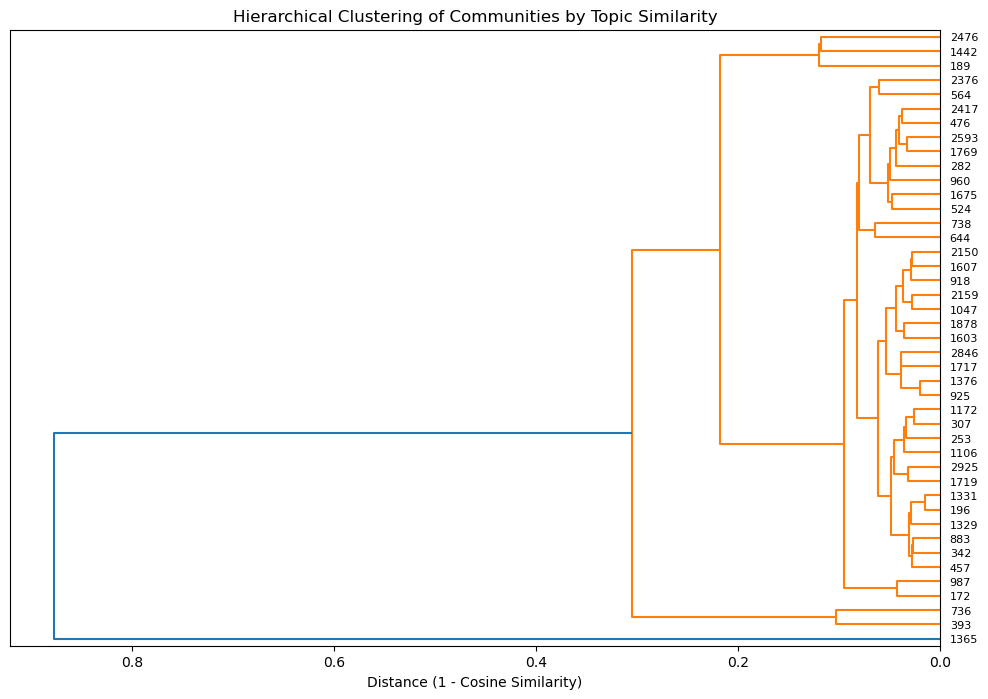

In [80]:
from scipy.cluster.hierarchy import linkage, dendrogram

# ==============================================================
# Step 1: Build Community-Topic Matrix
# ==============================================================

# Create a mapping from (level, topic_id) to a unique index
all_topics = list(topic_counts.keys())
topic_to_idx = {topic: idx for idx, topic in enumerate(all_topics)}

# Initialize a matrix: rows = communities, columns = topics
n_communities = len(all_communities)
n_topics = len(all_topics)
community_topic_matrix = np.zeros((n_communities, n_topics))

# Populate the matrix with normalized topic counts per community
for comm_idx, comm in enumerate(all_communities):
    total = 0
    # Sum counts for all topics in this community
    for topic in all_topics:
        count = topic_counts[topic].get(comm, 0)
        community_topic_matrix[comm_idx, topic_to_idx[topic]] = count
        total += count
    # Normalize by total counts in the community
    if total > 0:
        community_topic_matrix[comm_idx, :] /= total

# ==============================================================
# Step 2: Compute Pairwise Community Similarity
# ==============================================================

# Compute cosine similarity between communities
community_similarity = cosine_similarity(community_topic_matrix)

# ==============================================================
# Step 3: Cluster Communities by Similarity
# ==============================================================

# Convert similarity to distance (1 - similarity)
distance_matrix = 1 - community_similarity
np.fill_diagonal(distance_matrix, 0)  # Ensure diagonal is 0

# Perform hierarchical clustering
linked = linkage(distance_matrix, method='average')

# Plot dendrogram
plt.figure(figsize=(12, 8))
dendrogram(linked,
           labels=[str(c) for c in all_communities],
           orientation='left',
           leaf_font_size=8)
plt.title("Hierarchical Clustering of Communities by Topic Similarity")
plt.xlabel("Distance (1 - Cosine Similarity)")
plt.show()

Most topics are quite similar and this is probably because the abstract are all statistical papers.